In [1]:
import pertpy as pt
import pickle as pkl
import scanpy as sc
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
from scipy import stats
from scipy import sparse 
from statsmodels.sandbox.stats.multicomp import multipletests


Installed version 0.4.0 of pertpy is outdated. Newest version is 0.5.0!

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
%load_ext autoreload
%autoreload 2

import importlib
importlib.reload(pt)

Installed version 0.4.0 of pertpy is outdated. Newest version is 0.5.0!

<module 'pertpy' from '/Users/tessa/miniforge3/envs/pertpy5/lib/python3.9/site-packages/pertpy/__init__.py'>

In [3]:
def test_association(adata, celltype_label = "Cluster", sample_label="Sample", condition_label = "Efficacy", conditions_compare = ("PR","SD")): 
    """
    Tests association between etc 
    Note: benjamini-hochberg corrects for the number of cell types, NOT the number of MCPs
    """
    
    pvals = pd.DataFrame(1, adata.obs[celltype_label].unique(), ["mcp_"+str(n) for n in range(0,10)])
    tstats = pd.DataFrame(1, adata.obs[celltype_label].unique(), ["mcp_"+str(n) for n in range(0,10)])
    pvals_adj = pd.DataFrame(1, adata.obs[celltype_label].unique(), ["mcp_"+str(n) for n in range(0,10)])
    
    response = adata.obs.groupby(sample_label)[condition_label].agg(pd.Series.mode)
    res = dict()
    for celltype in adata.obs[celltype_label].unique():
        df = adata.obs[adata.obs[celltype_label]==celltype]

        for mcpnum in ["mcp_"+str(n) for n in range(0,10)]:
            mns = df.groupby(sample_label)[mcpnum].mean()
            mns = pd.concat([mns,response],axis=1)
            res = stats.ttest_ind(mns[mns[condition_label]==conditions_compare[0]][mcpnum],mns[mns[condition_label]==conditions_compare[1]][mcpnum])
            pvals.loc[celltype, mcpnum]=res[1]
            tstats.loc[celltype, mcpnum]=res[0]
            #return(res)
            #
    for mcpnum in ["mcp_"+str(n) for n in range(0,10)]:
        pvals_adj[mcpnum]=multipletests(pvals[mcpnum], method='fdr_bh')[1]
    return pvals,tstats,pvals_adj

In [4]:
def plot_split_violins(adata, mcp = "mcp_0", split="Efficacy", celltype_key = "Cluster"):
    df = sc.get.obs_df(adata, [celltype_key,mcp, split])
  

    p2 = sns.violinplot(data=df, x=celltype_key,y=mcp,hue=split, split=True)
    p2.set_xticklabels(p2.get_xticklabels(), rotation=45)


In [5]:
def mcp_pairsplot(adata, celltype_key = "Cluster", color = "Efficacy", mcp = "mcp_0", sample_key = "Sample"):
    mean_mcps = adata.obs.groupby([sample_key,celltype_key])[mcp].mean()
    mean_mcps = mean_mcps.reset_index()
    mcp_pivot = pd.pivot(mean_mcps[[sample_key,celltype_key,mcp]],index=sample_key,columns = celltype_key )[mcp]
    mcp_pivot = pd.concat([mcp_pivot,adata.obs.groupby([sample_key]).agg(pd.Series.mode)[color]],axis=1)
    sns.pairplot(mcp_pivot, corner=True, hue=color)
    

In [6]:
### IMPORT FROM THE BS SOLVER
adata=sc.read_h5ad("output/tumor_pre_DLG_normalizeTrue_bssolver_071023.h5ad")

with open("output/tumor_pre_DLG_normalizeTrue_bssolver_071023.pkl", 'rb') as file:
    a = pkl.load(file)
file.close()


In [7]:
a['pvals_adj'] = test_association(adata)[2]# interested in MCP_4, MCP_8

In [8]:
a['pvals']['mcp_4']

t_Bmem-CD27         0.007831
t_CD4_Tcm-LMNA      0.008501
t_CD4_Treg-FOXP3    0.024958
t_CD8_MAIT-KLRB1    0.012136
t_CD8_Tem-GZMK      0.028376
t_CD8_Trm-ZNF683    0.025198
t_Tn-LEF1           0.011209
t_mono-FCN1         0.079806
t_pB-IGHG1          0.008574
Name: mcp_4, dtype: float64

In [9]:
multipletests(a['pvals']['mcp_4'],alpha=0.5,method='fdr_bh')

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True]),
 array([0.02184415, 0.02184415, 0.03192251, 0.02184415, 0.03192251,
        0.03192251, 0.02184415, 0.0798063 , 0.02184415]),
 0.07412528771270954,
 0.05555555555555555)

In [10]:
a['pvals']['mcp_4']

t_Bmem-CD27         0.007831
t_CD4_Tcm-LMNA      0.008501
t_CD4_Treg-FOXP3    0.024958
t_CD8_MAIT-KLRB1    0.012136
t_CD8_Tem-GZMK      0.028376
t_CD8_Trm-ZNF683    0.025198
t_Tn-LEF1           0.011209
t_mono-FCN1         0.079806
t_pB-IGHG1          0.008574
Name: mcp_4, dtype: float64

In [11]:
a['ct_subs']['t_Bmem-CD27']

AnnData object with n_obs × n_vars = 7283 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'mcp_0', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5', 'mcp_6', 'mcp_7', 'mcp_8', 'mcp_9'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [12]:
a['pvals_adj']['mcp_4']< 0.03

t_Bmem-CD27          True
t_CD4_Tcm-LMNA       True
t_CD4_Treg-FOXP3    False
t_CD8_MAIT-KLRB1     True
t_CD8_Tem-GZMK      False
t_CD8_Trm-ZNF683    False
t_Tn-LEF1            True
t_mono-FCN1         False
t_pB-IGHG1           True
Name: mcp_4, dtype: bool

In [13]:
multipletests?

Signature:
multipletests(
    pvals,
    alpha=0.05,
    method='hs',
    is_sorted=False,
    returnsorted=False,
)
Docstring:
Test results and p-value correction for multiple tests

Parameters
----------
pvals : array_like, 1-d
    uncorrected p-values.   Must be 1-dimensional.
alpha : float
    FWER, family-wise error rate, e.g. 0.1
method : str
    Method used for testing and adjustment of pvalues. Can be either the
    full name or initial letters. Available methods are:

    - `bonferroni` : one-step correction
    - `sidak` : one-step correction
    - `holm-sidak` : step down method using Sidak adjustments
    - `holm` : step-down method using Bonferroni adjustments
    - `simes-hochberg` : step-up method  (independent)
    - `hommel` : closed method based on Simes tests (non-negative)
    - `fdr_bh` : Benjamini/Hochberg  (non-negative)
    - `fdr_by` : Benjamini/Yekutieli (negative)
    - `fdr_tsbh` : two stage fdr correction (non-negative)
    - `fdr_tsbky` : two stage fdr cor

In [14]:
a['pvals']['mcp_4']< 0.03

t_Bmem-CD27          True
t_CD4_Tcm-LMNA       True
t_CD4_Treg-FOXP3     True
t_CD8_MAIT-KLRB1     True
t_CD8_Tem-GZMK       True
t_CD8_Trm-ZNF683     True
t_Tn-LEF1            True
t_mono-FCN1         False
t_pB-IGHG1           True
Name: mcp_4, dtype: bool

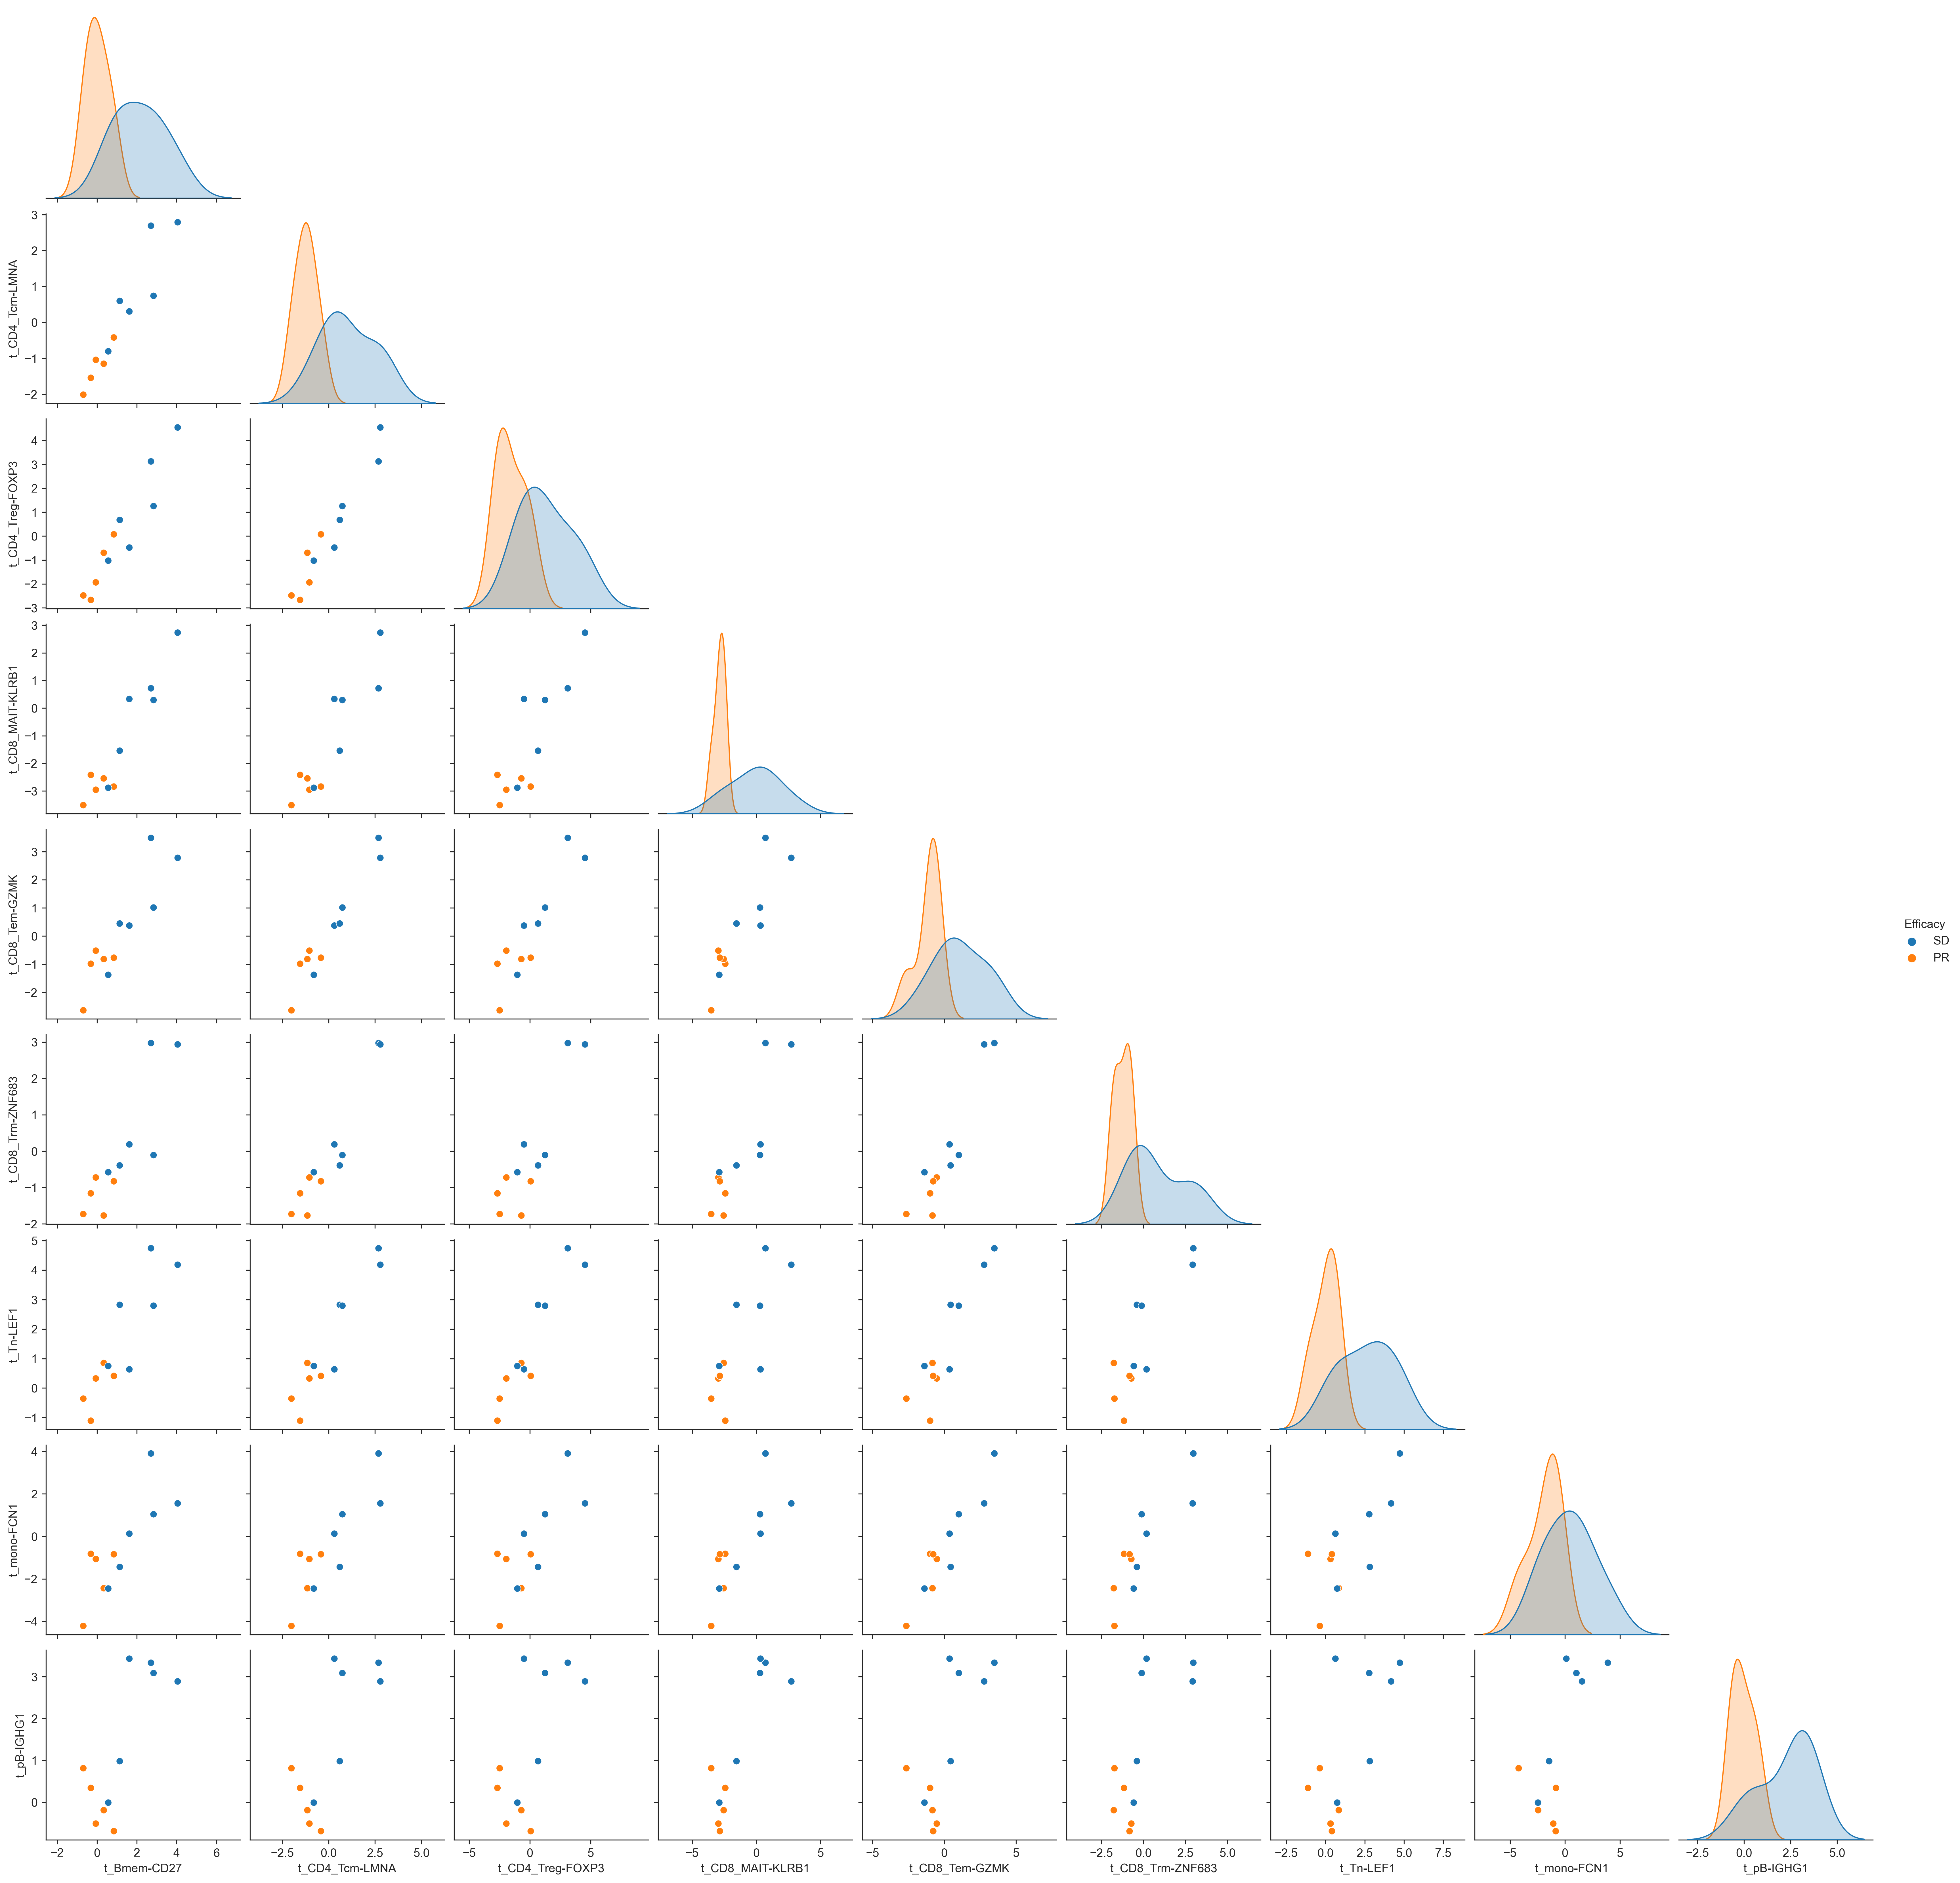

In [15]:
# YUP, definitely going to continue with MCP4
mcp_pairsplot(adata, celltype_key = "Cluster", color = "Efficacy", mcp = "mcp_4", sample_key = "Sample")


In [23]:
## Make mini plot with just the three most significant cell types 
mini = adata[adata.obs["Cluster"].isin(a['pvals'][a['pvals']['mcp_4']< 0.01].index.values)].copy()

In [237]:
mini.obs = mini.obs.replace({"SD":"Stable disease", "PR":"Partial response"})
mini.obs = mini.obs.replace({"t_CD4_Tcm-LMNA":"CD4 central memory T cells", "t_pB-IGHG1":"Plasma B cells", "t_Bmem-CD27":"Memory B cells"})

mcp_pairsplot(mini, celltype_key = "Cluster", color = "Efficacy", mcp = "mcp_4", sample_key = "Sample")
plt.savefig("output/mini_01_bs_pairsplot.pdf")
plt.savefig("output/mini_01_bs_pairsplot.png")

In [16]:
### MCP genes from loadings 

def project_mcps(adata, ws, celltype_label="Cluster", obsm_key="X_pca", remove_celltypes=True):
    """
    Project the X_pca through ws for all cells and store the results in the 'obs' attribute of 'adata'.
    Note that the Dialogue scores returned by calculate_multifactor_PMD have additional adjustments, so 
    the projected ws here are not equivalent to the MCPs returned by dlg for the same set of weights ws. 

    Parameters:
        adata (AnnData): Annotated data matrix with observations (cells) as rows and features (genes) as columns.
        ws (dict): A dictionary containing cell type-specific gene loadings matrices as values,
                   where each key corresponds to a cell type label.
        celltype_label (str, optional): The name of the column in 'adata.obs' that contains cell type labels.
                                        Defaults to 'Cluster'.
        obsm_key (str, optional): The key in 'adata.obsm' where the PCA matrix is stored.
                                  Defaults to 'X_pca'.
        remove_celltypes (bool, optional): If True, filter out cells from 'adata' that do not belong to any cell type
                                           specified in 'ws'. Defaults to True.

    Returns:
        AnnData: The updated annotated data matrix with cell type-specific MCP loadings stored in the 'obs' attribute.
    """
    # Check if the cell type labels in 'adata' match the keys in 'ws'
    if set(adata.obs[celltype_label].unique().to_list()) != set(ws.keys()):
        print("Cell types do not match between 'adata' and 'ws'.")

    # Optionally, filter out cells not present in any cell type specified in 'ws'
    if remove_celltypes:
        adata = adata[adata.obs[celltype_label].isin(ws.keys())]

    # Initialize a dictionary to store the MCP loadings for each cell type
    output = {}

    # Determine the number of MCP columns based on the first cell type in 'ws'
    n_mcps = ws[next(iter(ws))].shape[1]

    # Generate a list of MCP column names: "mcp_0", "mcp_1", ..., "mcp_{n_mcps-1}"
    mcp_list = ["mcp_" + str(i) for i in range(n_mcps)]

    # Initialize the MCP columns to 0 for all cells in 'adata'
    adata.obs[mcp_list] = 0

    # Perform the projection for each cell type specified in 'ws'
    for celltype in ws.keys():
        # Create a boolean mask to select cells belonging to the current cell type
        celltype_mask = adata.obs[celltype_label] == celltype

        # Calculate the MCP loadings for the selected cells and store the result in 'output'
        output[celltype] = np.matmul(adata.obsm[obsm_key][celltype_mask], ws[celltype])

        # Update the corresponding MCP columns in 'adata.obs' with the calculated loadings
        adata.obs.loc[celltype_mask, mcp_list] = output[celltype]

    return adata

In [18]:
adata_stripped = adata.copy()
adata_stripped.obs = adata_stripped.obs.drop(columns=["mcp_" + str(i) for i in range(10)], axis=1)


adata_stripped.obs
output = project_mcps(adata_stripped, a['ws'])
output.obs

Sample Patient Origin      Tissue Efficacy  \
Cell barcode                                                                  
AAATGCCTCATCTGCC.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
AATCCAGAGCGTTCCG.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
ACAGCCGAGCACCGCT.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
ACCGTAAAGCTAACTC.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
ACGAGCCTCGTAGGTT.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
...                                 ...     ...    ...         ...      ...   
CGGGTCAGTTCCCGAG.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
GCTTGAACAGGCTGAA.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
GTCGGGTGTCCGAATT.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
TCATTTGTCAATACCG.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
TCTCATATCCAAAGTC.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   

                                     Group         Treatment  \
Cell barcode                                                   
AAATGCCTCATCTGCC.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo   
AATCCAGAGCGTTCCG.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo   
ACAGCCGAGCACCGCT.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo   
ACCGTAAAGCTAACTC.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo   
ACGAGCCTCGTAGGTT.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo   
...                                    ...               ...   
CGGGTCAGTTCCCGAG.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo   
GCTTGAACAGGCTGAA.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo   
GTCGGGTGTCCGAATT.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo   
TCATTTGTCAATACCG.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo   
TCTCATATCCAAAGTC.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo   

                             Number of counts  Number of genes Major celltype  \
Cell barcode                                                                    
AAATGCCTCATCTGCC.Pre_P007_t            1068.0            513.0         B cell   
AATCCAGAGCGTTCCG.Pre_P007_t            1309.0            545.0         B cell   
ACAGCCGAGCACCGCT.Pre_P007_t            1344.0            499.0         B cell   
ACCGTAAAGCTAACTC.Pre_P007_t             992.0            560.0         B cell   
ACGAGCCTCGTAGGTT.Pre_P007_t            1482.0            715.0         B cell   
...                                       ...              ...            ...   
CGGGTCAGTTCCCGAG.Pre_P004_t            1530.0            455.0         B cell   
GCTTGAACAGGCTGAA.Pre_P004_t           15601.0           1716.0         B cell   
GTCGGGTGTCCGAATT.Pre_P004_t           23259.0           1702.0         B cell   
TCATTTGTCAATACCG.Pre_P004_t           41441.0           1971.0         B cell   
TCTCATATCCAAAGTC.Pre_P004_t           13445.0           1418.0         B cell   

                             ...     mcp_0     mcp_1     mcp_2     mcp_3  \
Cell barcode                 ...                                           
AAATGCCTCATCTGCC.Pre_P007_t  ...  0.024630  1.731156 -0.744848 -1.153238   
AATCCAGAGCGTTCCG.Pre_P007_t  ... -0.015568  2.379186  0.599248 -0.514839   
ACAGCCGAGCACCGCT.Pre_P007_t  ... -0.587769  8.887239 -7.857848  1.351051   
ACCGTAAAGCTAACTC.Pre_P007_t  ... -0.932235  1.265569  1.186969  4.360674   
ACGAGCCTCGTAGGTT.Pre_P007_t  ...  1.184637  1.318599 -1.971468 -1.286478   
...                          ...       ...       ...       ...       ...   
CGGGTCAGTTCCCGAG.Pre_P004_t  ...  0.587343  8.492218 -4.851919  0.032954   
GCTTGAACAGGCTGAA.Pre_P004_t  ...  0.142078  3.853591 -3.314564 -1.735825   
GTCGGGTGTCCGAATT.Pre_P004_t  ... -0.874502  9.149309 -4.820769  1.425461   
TCATTTGTCAATACCG.Pre_P004_t  ... -0.753416  6.059690 -3.811425 -1.175423   
TCTCATATCCAAAGTC.Pre_P004_t  ... -1.531930  6.010535 -5.100586  1.297914   

                                mcp_4     mcp_5     mcp_6     mcp_7  \
Cell barcode                                              

OverloadedDict, wrapping:
	OrderedDict()
With overloaded keys:
	['neighbors'].

In [26]:
## OK this isn't actually what I wanted here, I wanted the loadings 
def plot_mcp_loadings(ct_subs, ws, MCPs = [0,1,2], vertical=True):
    """ Note, this only returns if len(MCPs) > 1"""
    for celltype in ct_subs.keys():
        dset=ct_subs[celltype]
        dset.varm['MCPs'] =  np.matmul(dset.varm['PCs'], ws[celltype])
        print(celltype)
        if vertical = True:
            sc.pl._anndata.ranking(dset, "varm","MCPs",indices = MCPs, n_points=30)
        else: 
            dset.var['mcp_loading']
            # there's definitely a way to do this but I'm not going to 
            #plot_loadings_vertical(dset,key =  )


In [ ]:
from matplotlib import rcParams
def plot_loadings_vertical(
    adata: AnnData,
    groups: Union[str, Sequence[str]] = None,
    n_genes: int = 20,
    gene_symbols: Optional[str] = None,
    key: Optional[str] = 'rank_genes_groups',
    fontsize: int = 8,
    ncols: int = 4,
    sharey: bool = False,
    show: Optional[bool] = None,
    save: Optional[bool] = None,
    ax: Optional[Axes] = None,
    title_override: Optional[str] = None,
    **kwds,
):
    """\
    Plot ranking of genes.
    Parameters
    ----------
    adata
        Annotated data matrix.
    groups
        The groups for which to show the gene ranking.
    gene_symbols
        Key for field in `.var` that stores gene symbols if you do not want to
        use `.var_names`.
    n_genes
        Number of genes to show.
    fontsize
        Fontsize for gene names.
    ncols
        Number of panels shown per row.
    sharey
        Controls if the y-axis of each panels should be shared. But passing
        `sharey=False`, each panel has its own y-axis range.
    {show_save_ax}
    Examples
    --------
    .. plot::
        :context: close-figs
        import scanpy as sc
        adata = sc.datasets.pbmc68k_reduced()
        sc.pl.rank_genes_groups(adata)
    Plot top 10 genes (default 20 genes)
    .. plot::
        :context: close-figs
        sc.pl.rank_genes_groups(adata, n_genes=10)
    .. currentmodule:: scanpy
    See also
    --------
    tl.rank_genes_groups
    """
    if 'n_panels_per_row' in kwds:
        n_panels_per_row = kwds['n_panels_per_row']
    else:
        n_panels_per_row = ncols
    if n_genes < 1:
        raise NotImplementedError(
            "Specifying a negative number for n_genes has not been implemented for "
            f"this plot. Received n_genes={n_genes}."
        )

    reference = str(adata.uns[key]['params']['reference'])
    group_names = adata.uns[key]['names'].dtype.names if groups is None else groups
    # one panel for each group
    # set up the figure
    n_panels_x = min(n_panels_per_row, len(group_names))
    n_panels_y = np.ceil(len(group_names) / n_panels_x).astype(int)

    from matplotlib import gridspec

    fig = plt.figure(
        figsize=(
            n_panels_x * 4,
            n_panels_y * 4.8,
        )
    )
    gs = gridspec.GridSpec(nrows=n_panels_y, ncols=n_panels_x, wspace=0.22, hspace=0.3)

    ax0 = None
    xmin = np.Inf
    xmax = -np.Inf
    for count, group_name in enumerate(group_names):
        gene_names = adata.uns[key]['names'][group_name][:n_genes]
        scores = adata.uns[key]['scores'][group_name][:n_genes]

        # Setting up axis, calculating y bounds
        if sharey:
            ymin = min(ymin, np.min(scores))
            ymax = max(ymax, np.max(scores))

            if ax0 is None:
                ax = fig.add_subplot(gs[count])
                ax0 = ax
            else:
                ax = fig.add_subplot(gs[count], sharey=ax0)
        else:
            ymin = np.min(scores)
            ymax = np.max(scores)
            ymax += 0.3 * (ymax - ymin)

            ax = fig.add_subplot(gs[count])
            ax.set_xlim(ymin-2, ymax)

        ax.set_ylim( n_genes +0.5,0)

        # Mapping to gene_symbols
        if gene_symbols is not None:
            if adata.raw is not None and adata.uns[key]['params']['use_raw']:
                gene_names = adata.raw.var[gene_symbols][gene_names]
            else:
                gene_names = adata.var[gene_symbols][gene_names]

        # Making labels
        for ig, gene_name in enumerate(gene_names):
            ax.text(
                scores[ig],
                ig+1,
                gene_name,
                rotation='horizontal',
                verticalalignment='bottom',
                horizontalalignment='center',
                fontsize=fontsize,
            )
        if title_override is not None:
            ax.set_title(title_override)
        else:
            ax.set_title('{} vs. {}'.format(group_name, reference))
        if count >= n_panels_x * (n_panels_y - 1):
            ax.set_xlabel('score')

        # print the 'score' label only on the first panel per row.
        if count % n_panels_x == 0:
            ax.set_ylabel('ranking')

    if sharey is True:
        ymax += 0.3 * (ymax - ymin)
        ax.set_ylim(ymin, ymax)

    #writekey = f"rank_genes_groups_{adata.uns[key]['params']['groupby']}"
    #savefig_or_show(writekey, show=show, save=save)

In [29]:
feature_loadings = pd.read_csv("data/seurat_feature_loadings.csv", index_col=0)
def fix_mcp_loadings(ct_subs, ws, MCPs = [0,1,2], feature_loadings=feature_loadings):
    """ Note, this only returns if len(MCPs) > 1"""
    ct_subs_loadings = {}
    for celltype in ct_subs.keys():
        dset=ct_subs[celltype]
        dset=dset.raw.to_adata()
        dset = dset[:,dset.var_names.isin(feature_loadings.index)]
        dset.varm['PCs'] = feature_loadings.loc[dset.var_names,:].values
        dset.varm['MCPs'] =  np.matmul(dset.varm['PCs'], ws[celltype])
        print(celltype)
        sc.pl._anndata.ranking(dset, "varm","MCPs",indices = MCPs, n_points=30, include_lowest=True)
        plt.show()
        ct_subs_loadings[celltype] = dset
    return ct_subs_loadings

In [28]:
ldings = fix_mcp_loadings(a['ct_subs'], a['ws'], MCPs=[3,4])
print(np.min(ldings['t_Bmem-CD27'].X))

t_Bmem-CD27


TypeError: ranking() got an unexpected keyword argument 'vertical'

t_Bmem-CD27


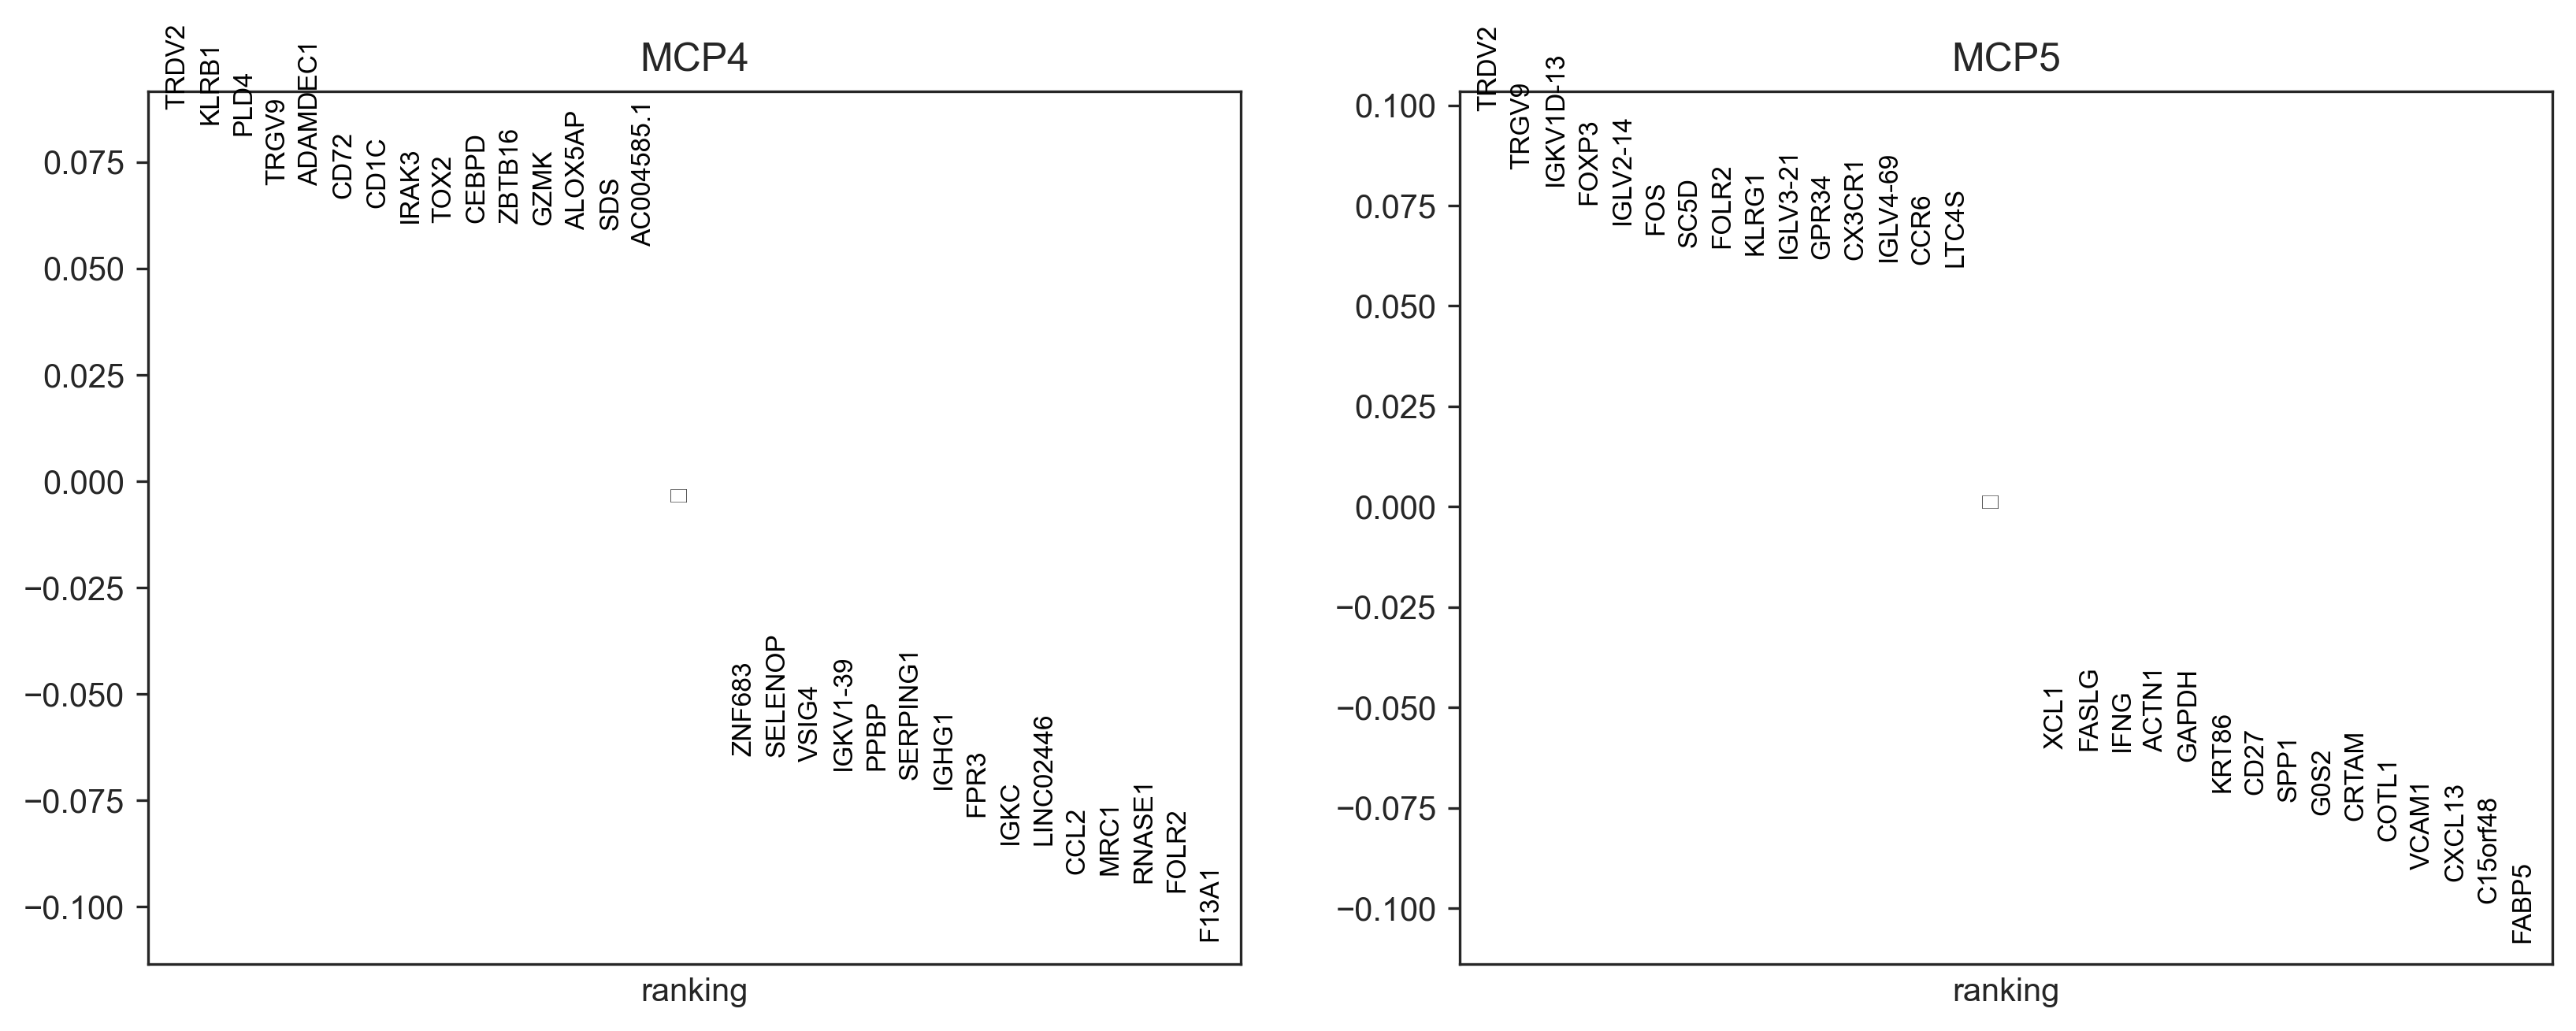

t_CD4_Tcm-LMNA


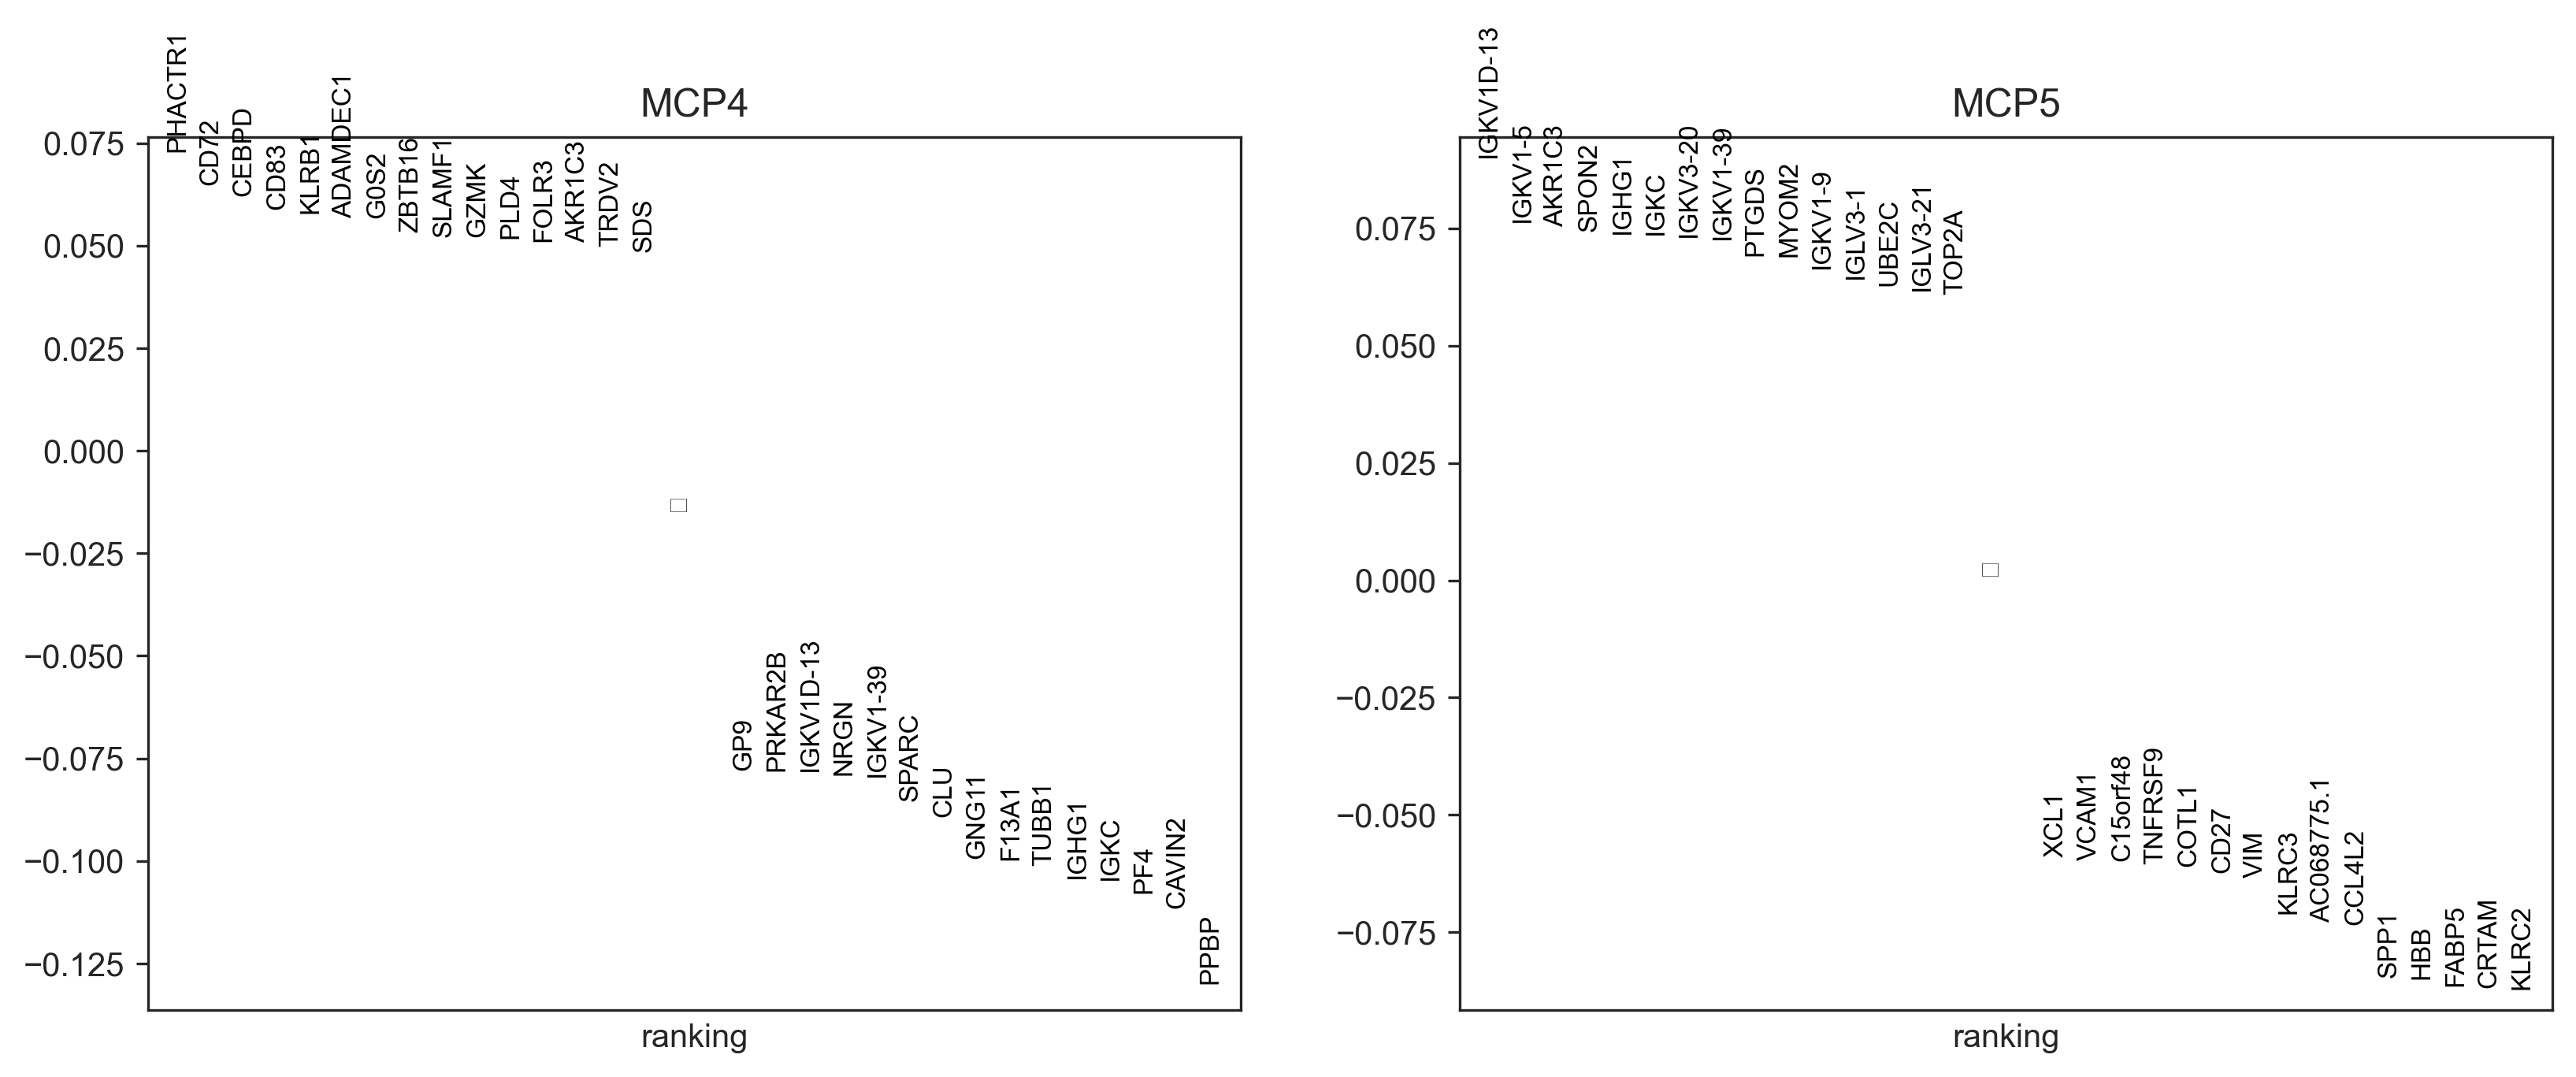

t_CD4_Treg-FOXP3


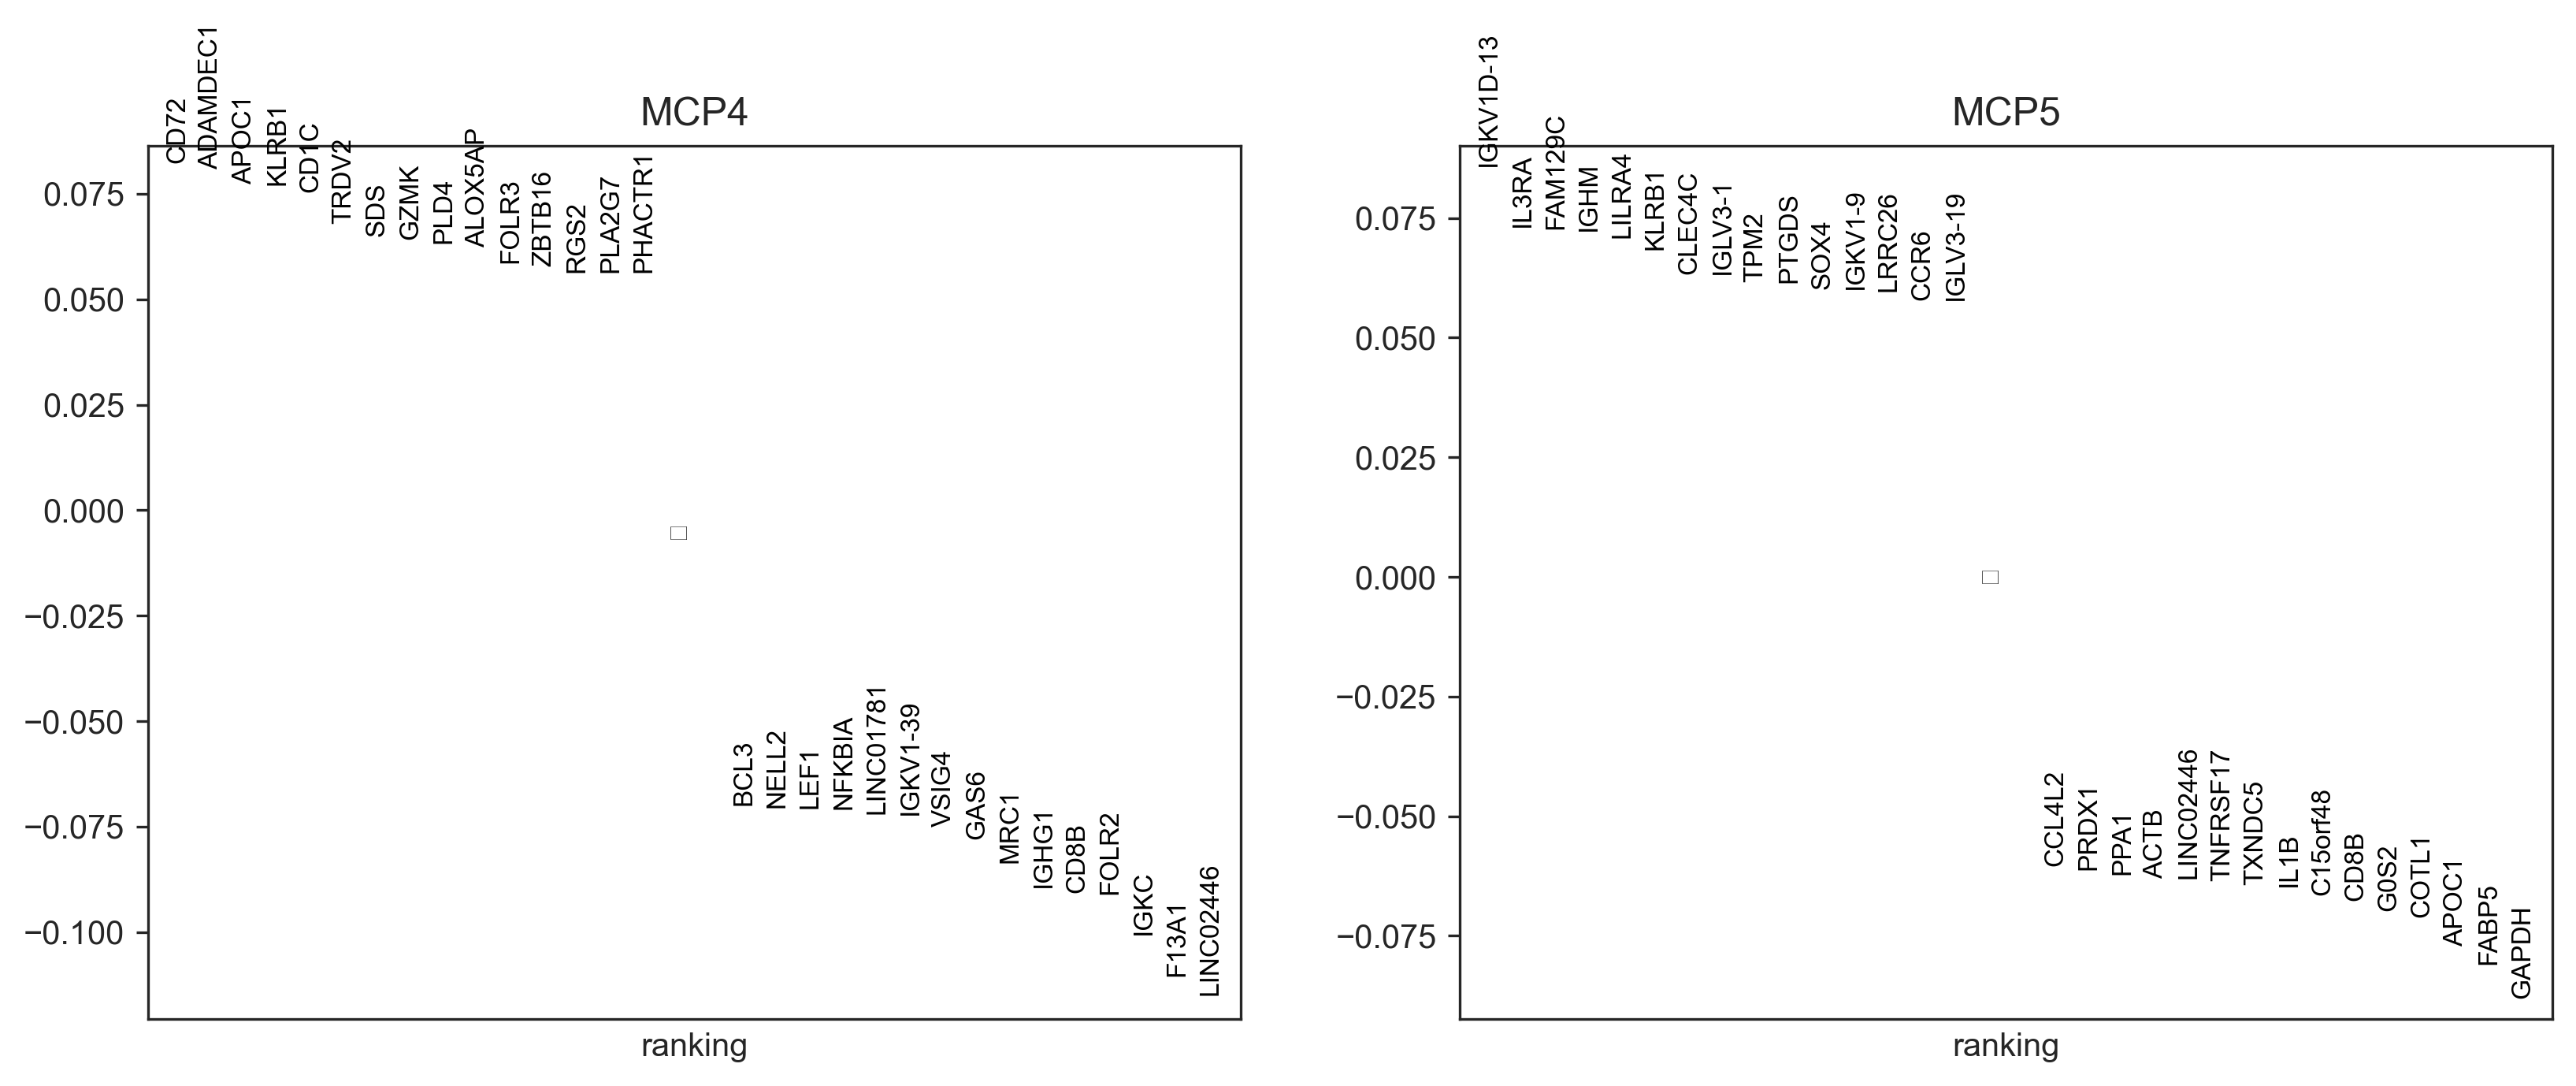

t_CD8_MAIT-KLRB1


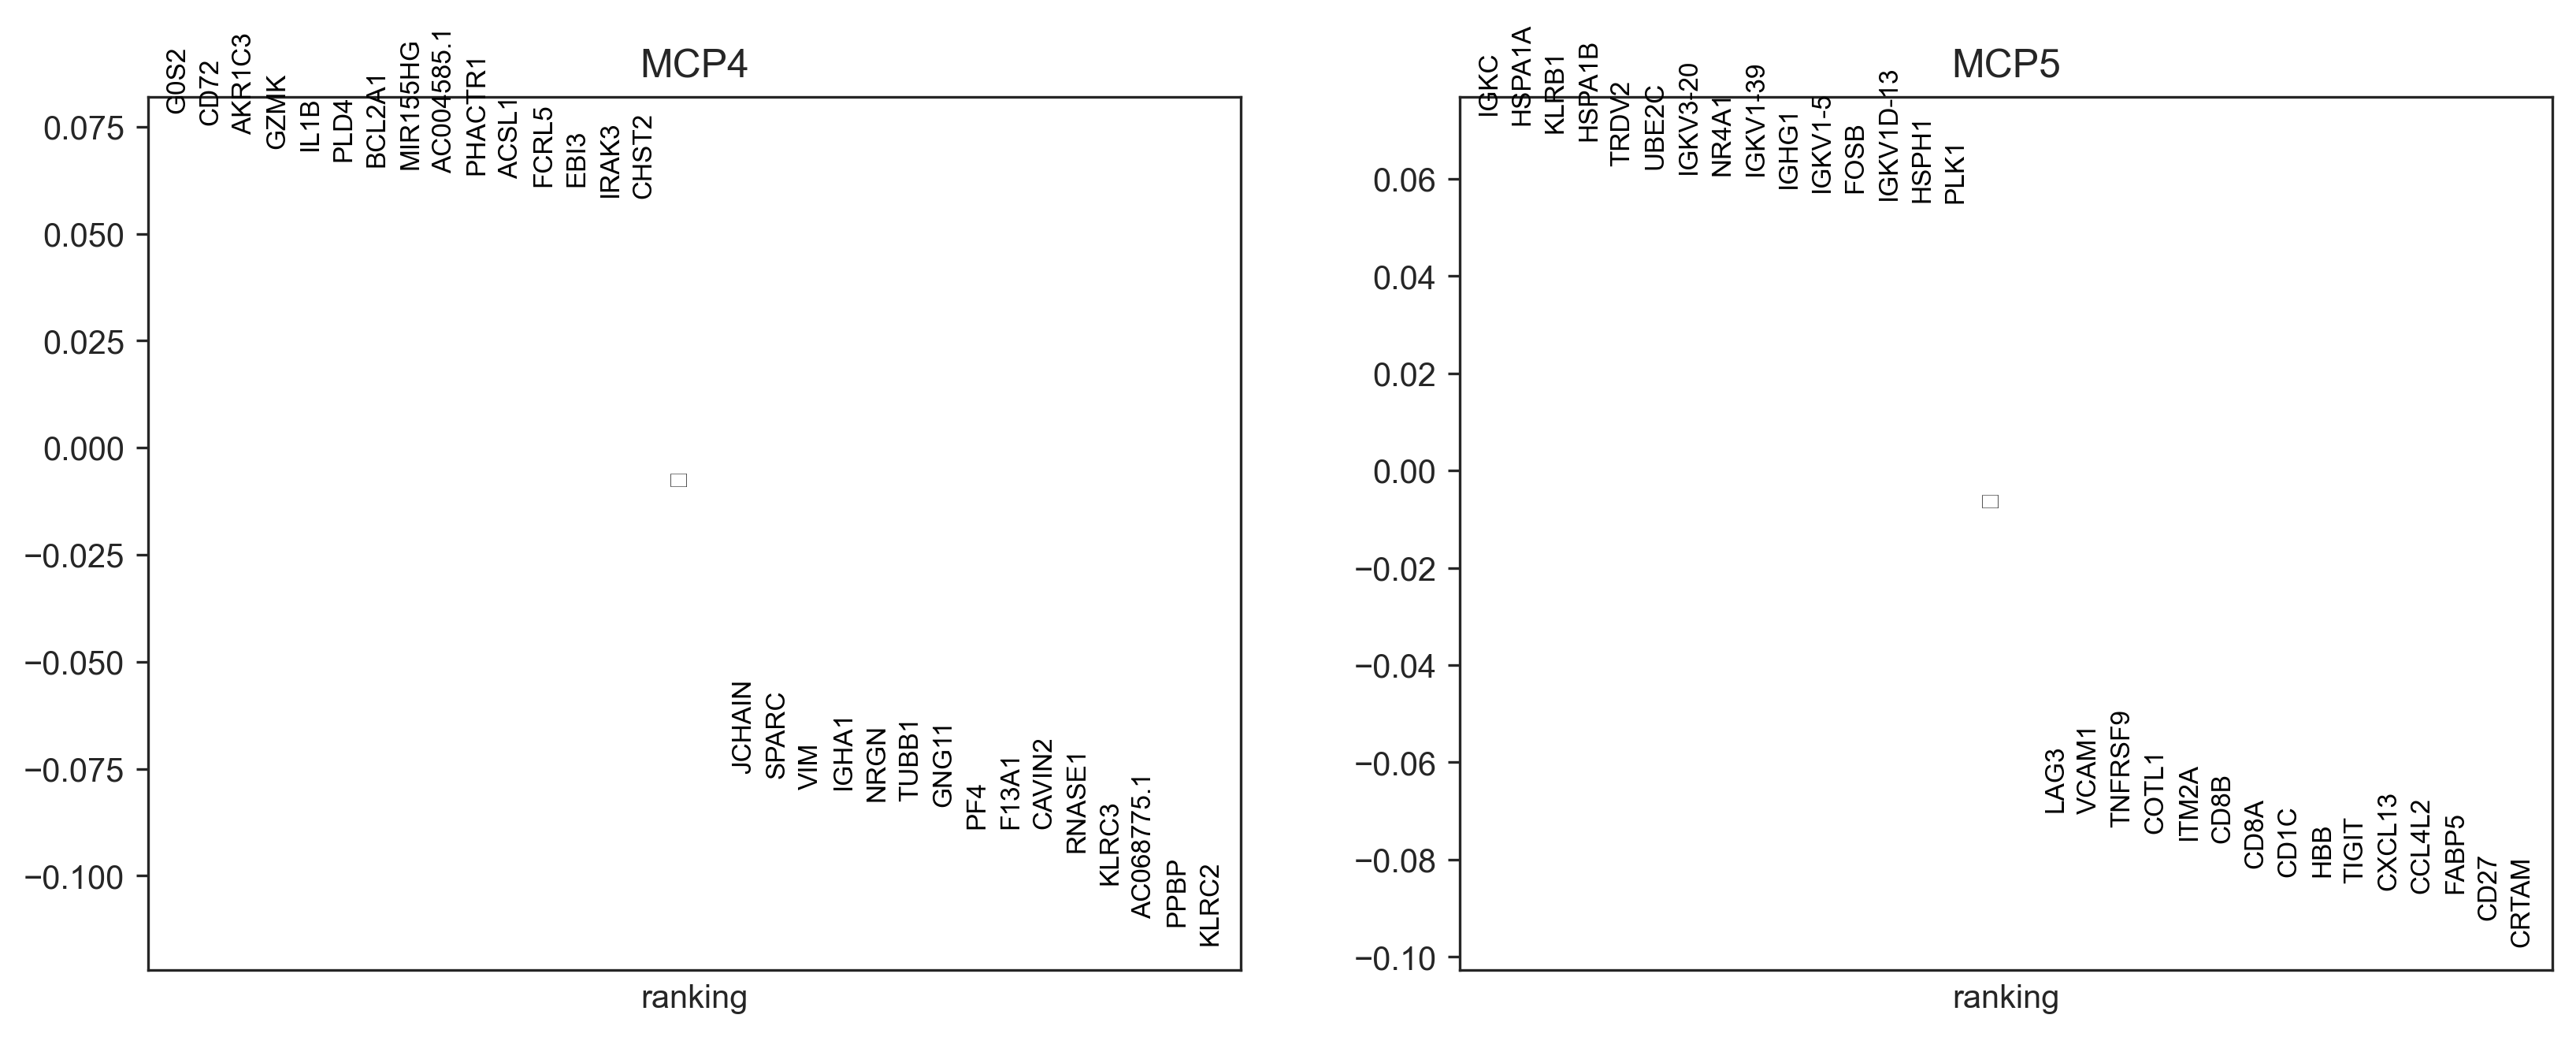

t_CD8_Tem-GZMK


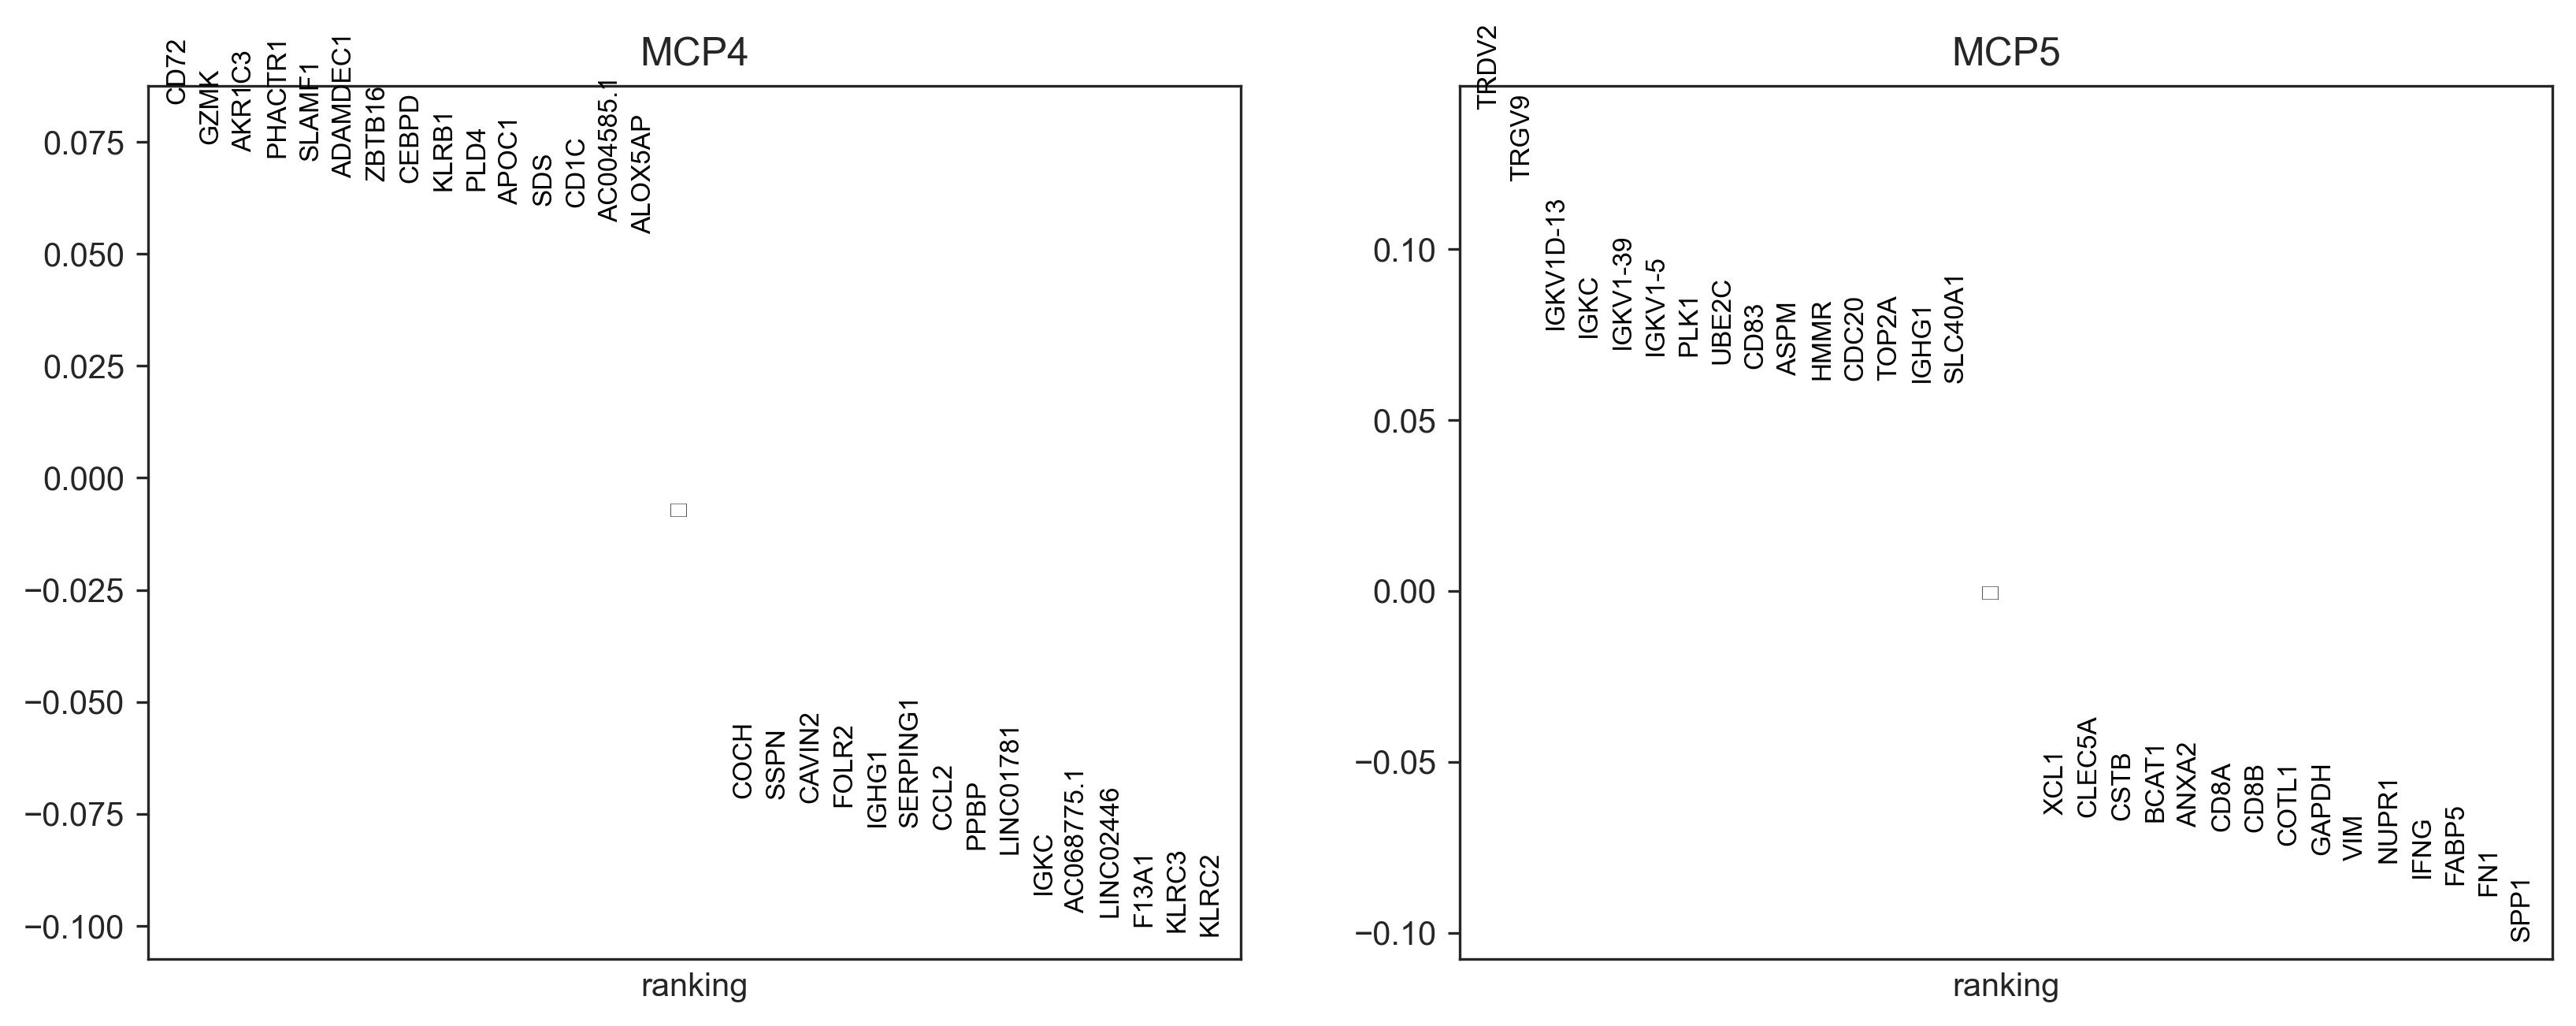

t_CD8_Trm-ZNF683


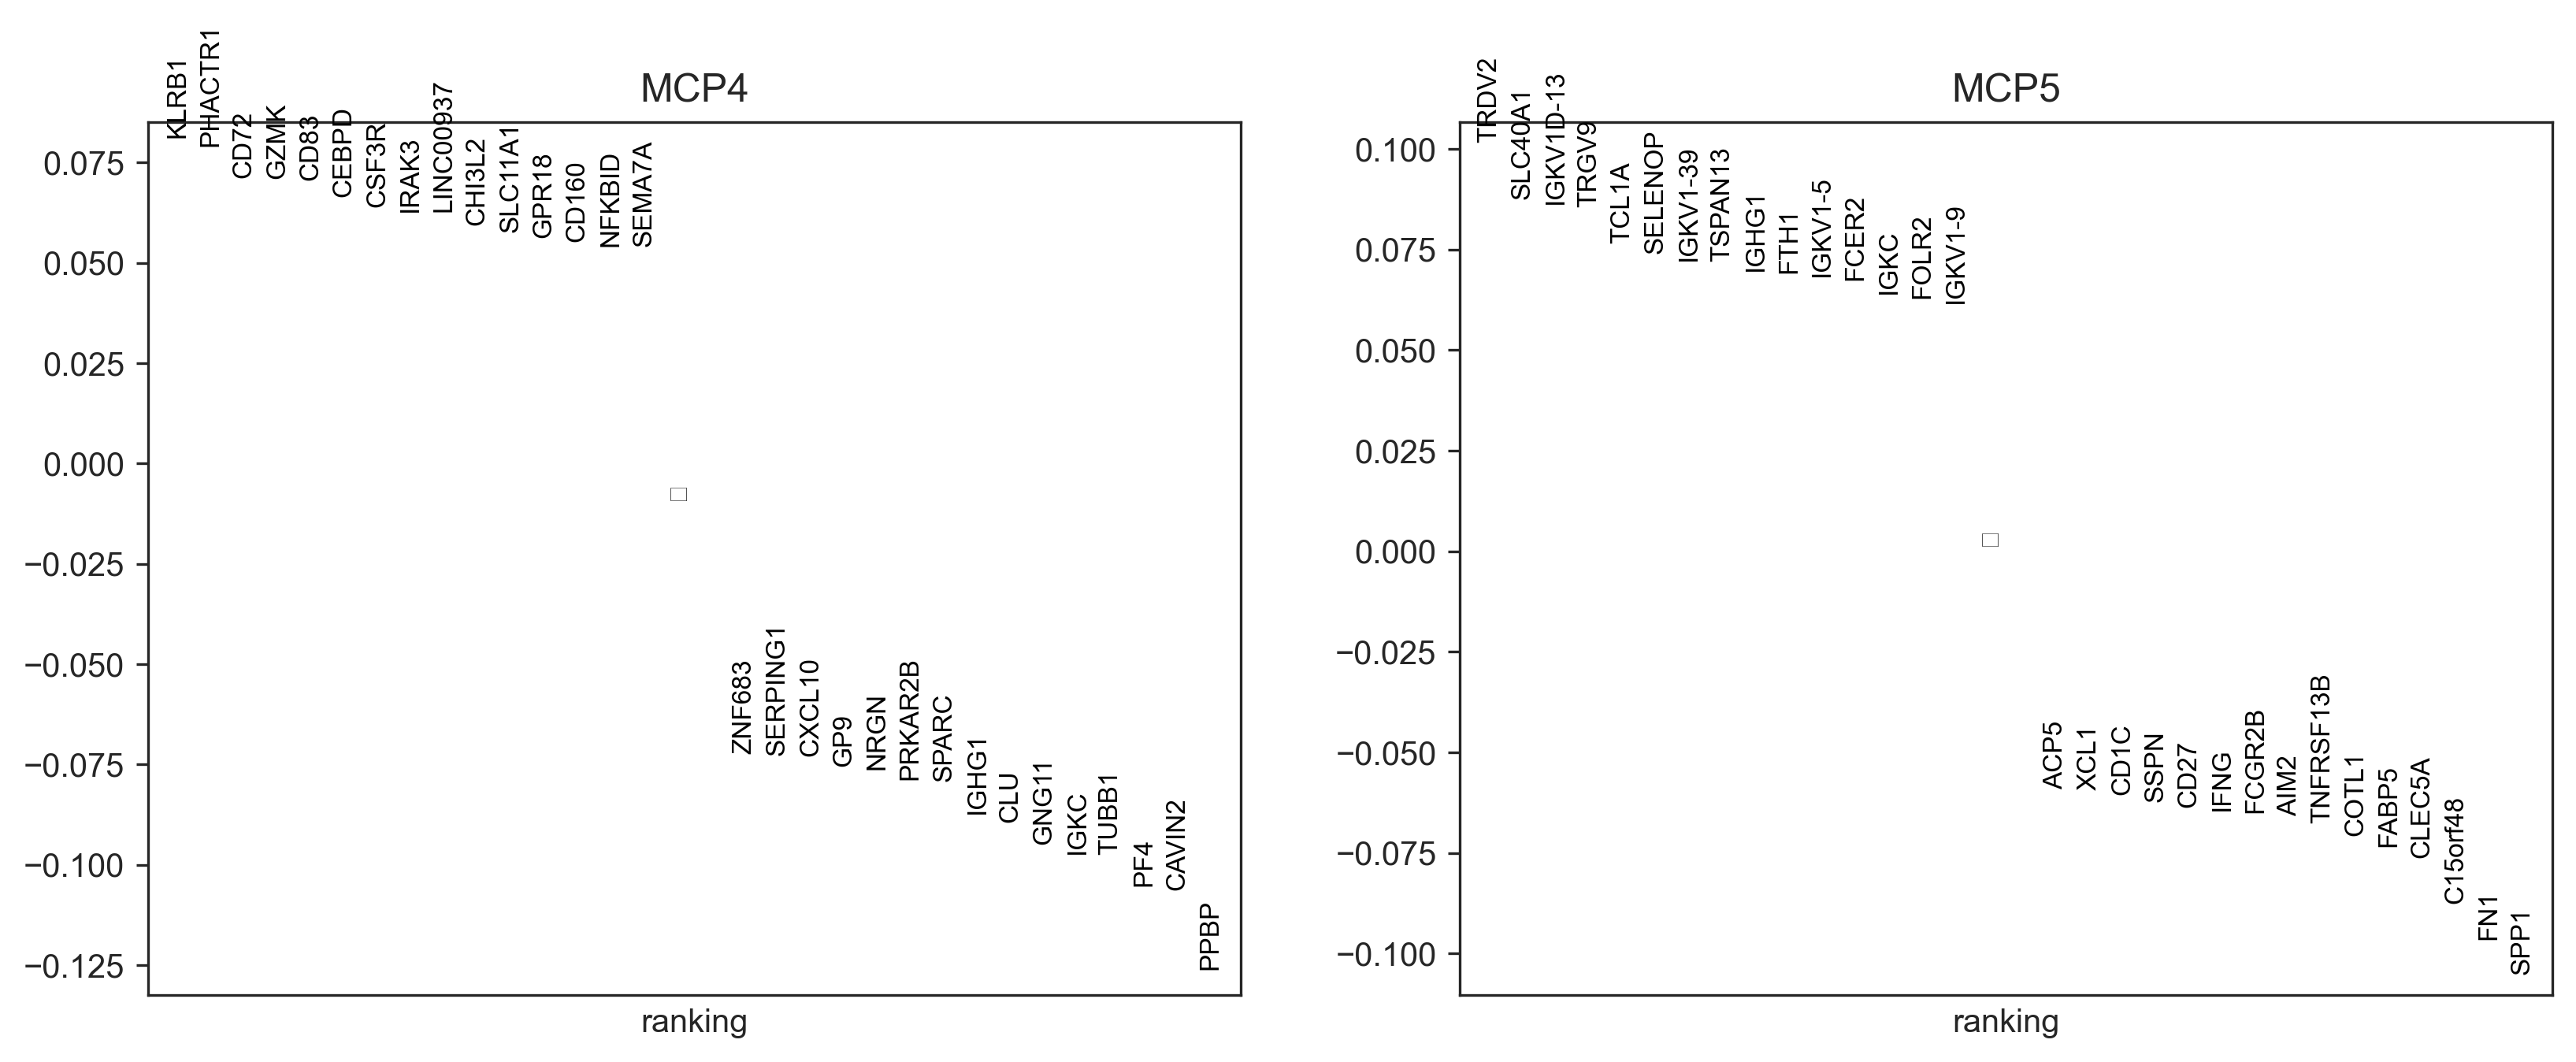

t_Tn-LEF1


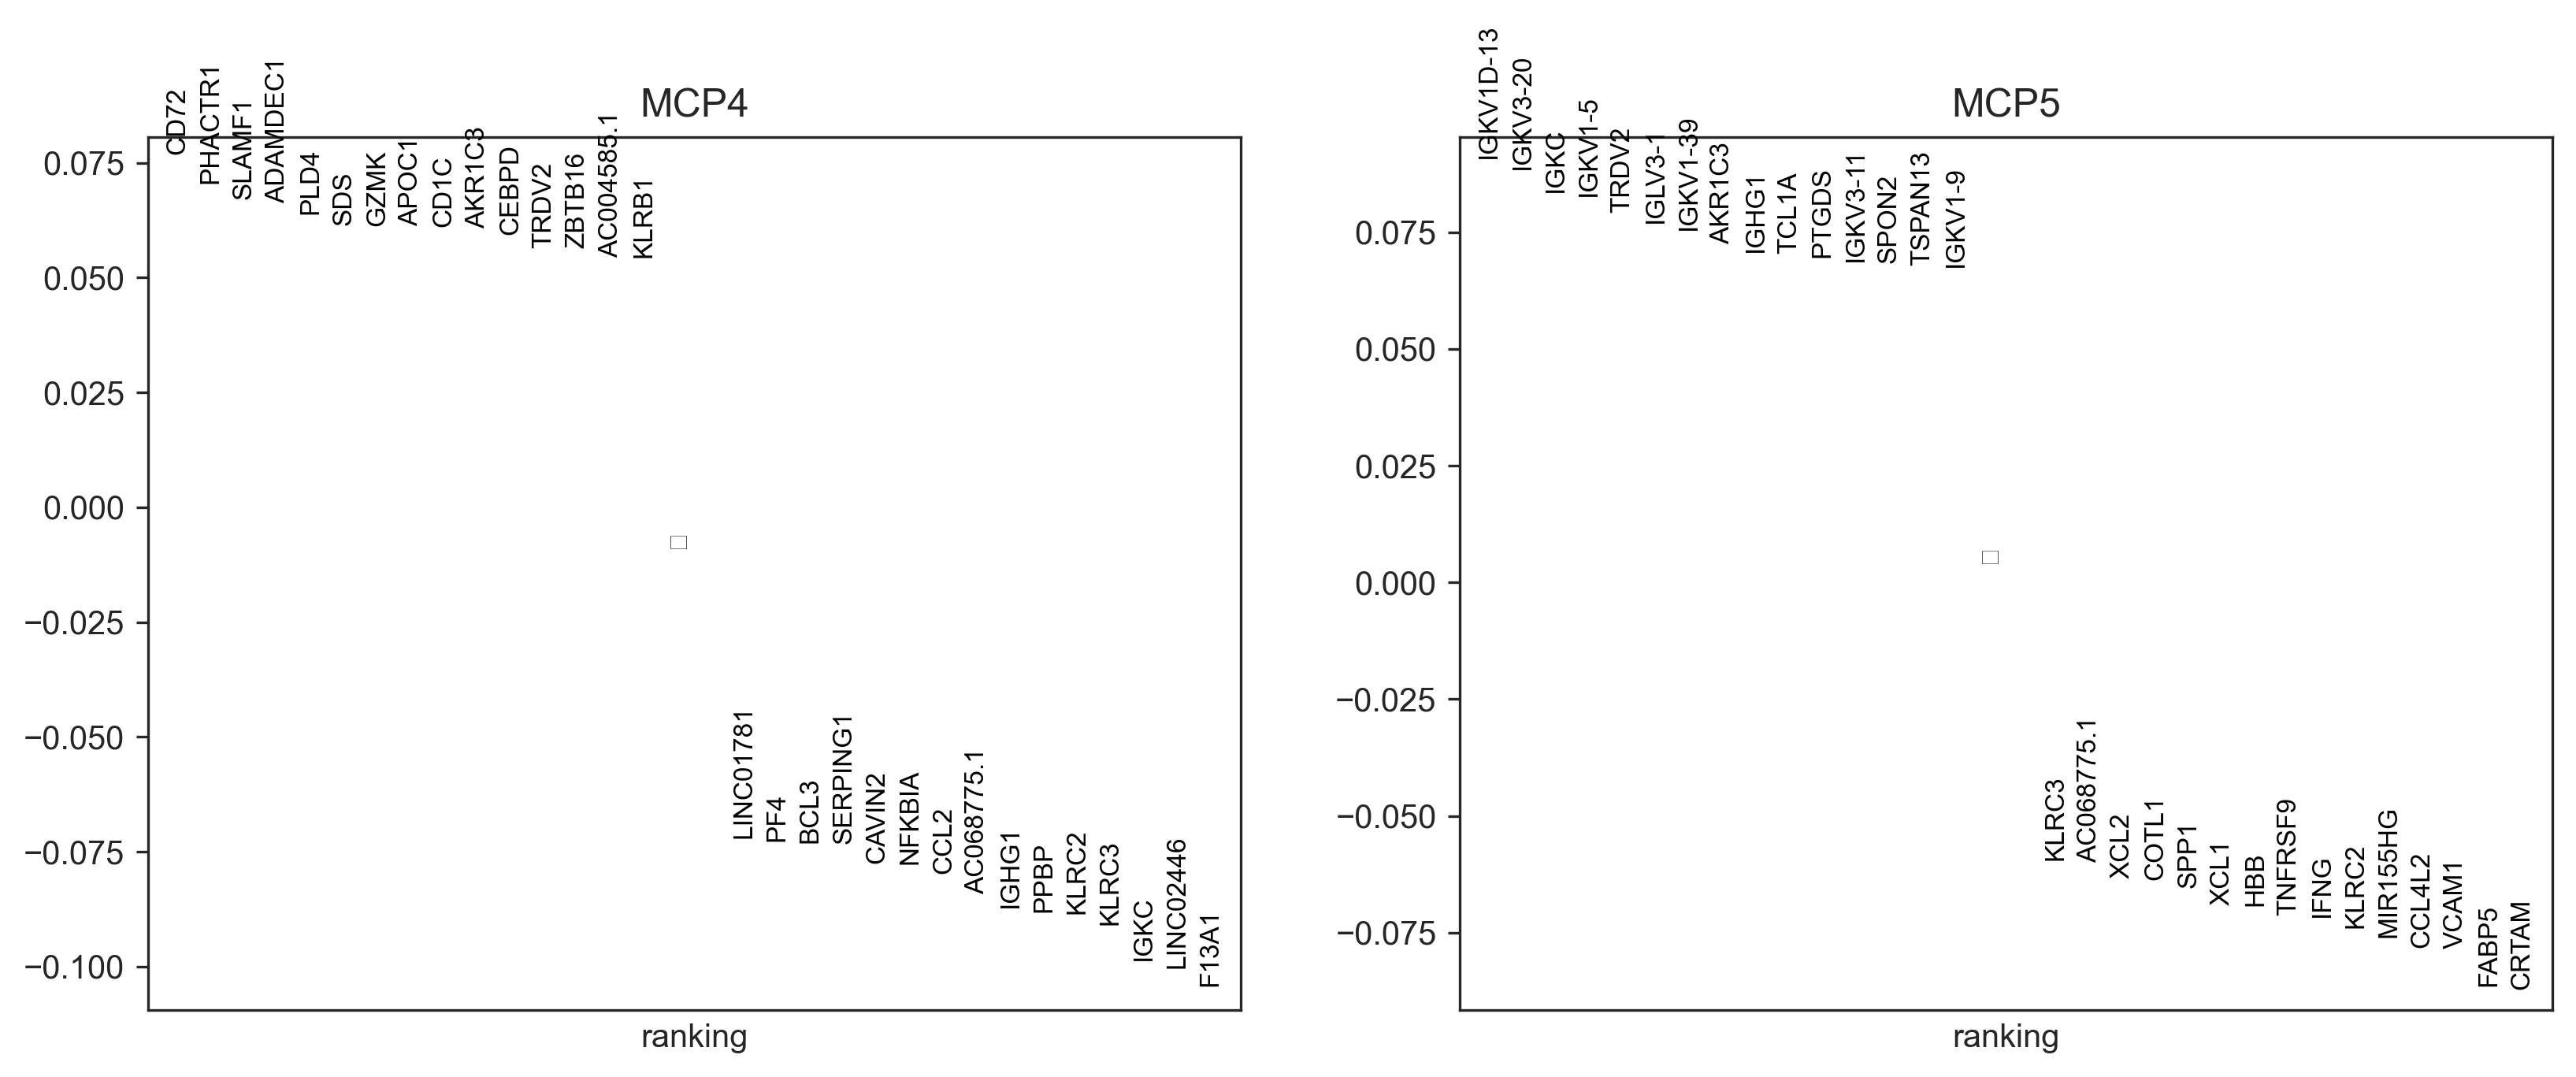

t_mono-FCN1


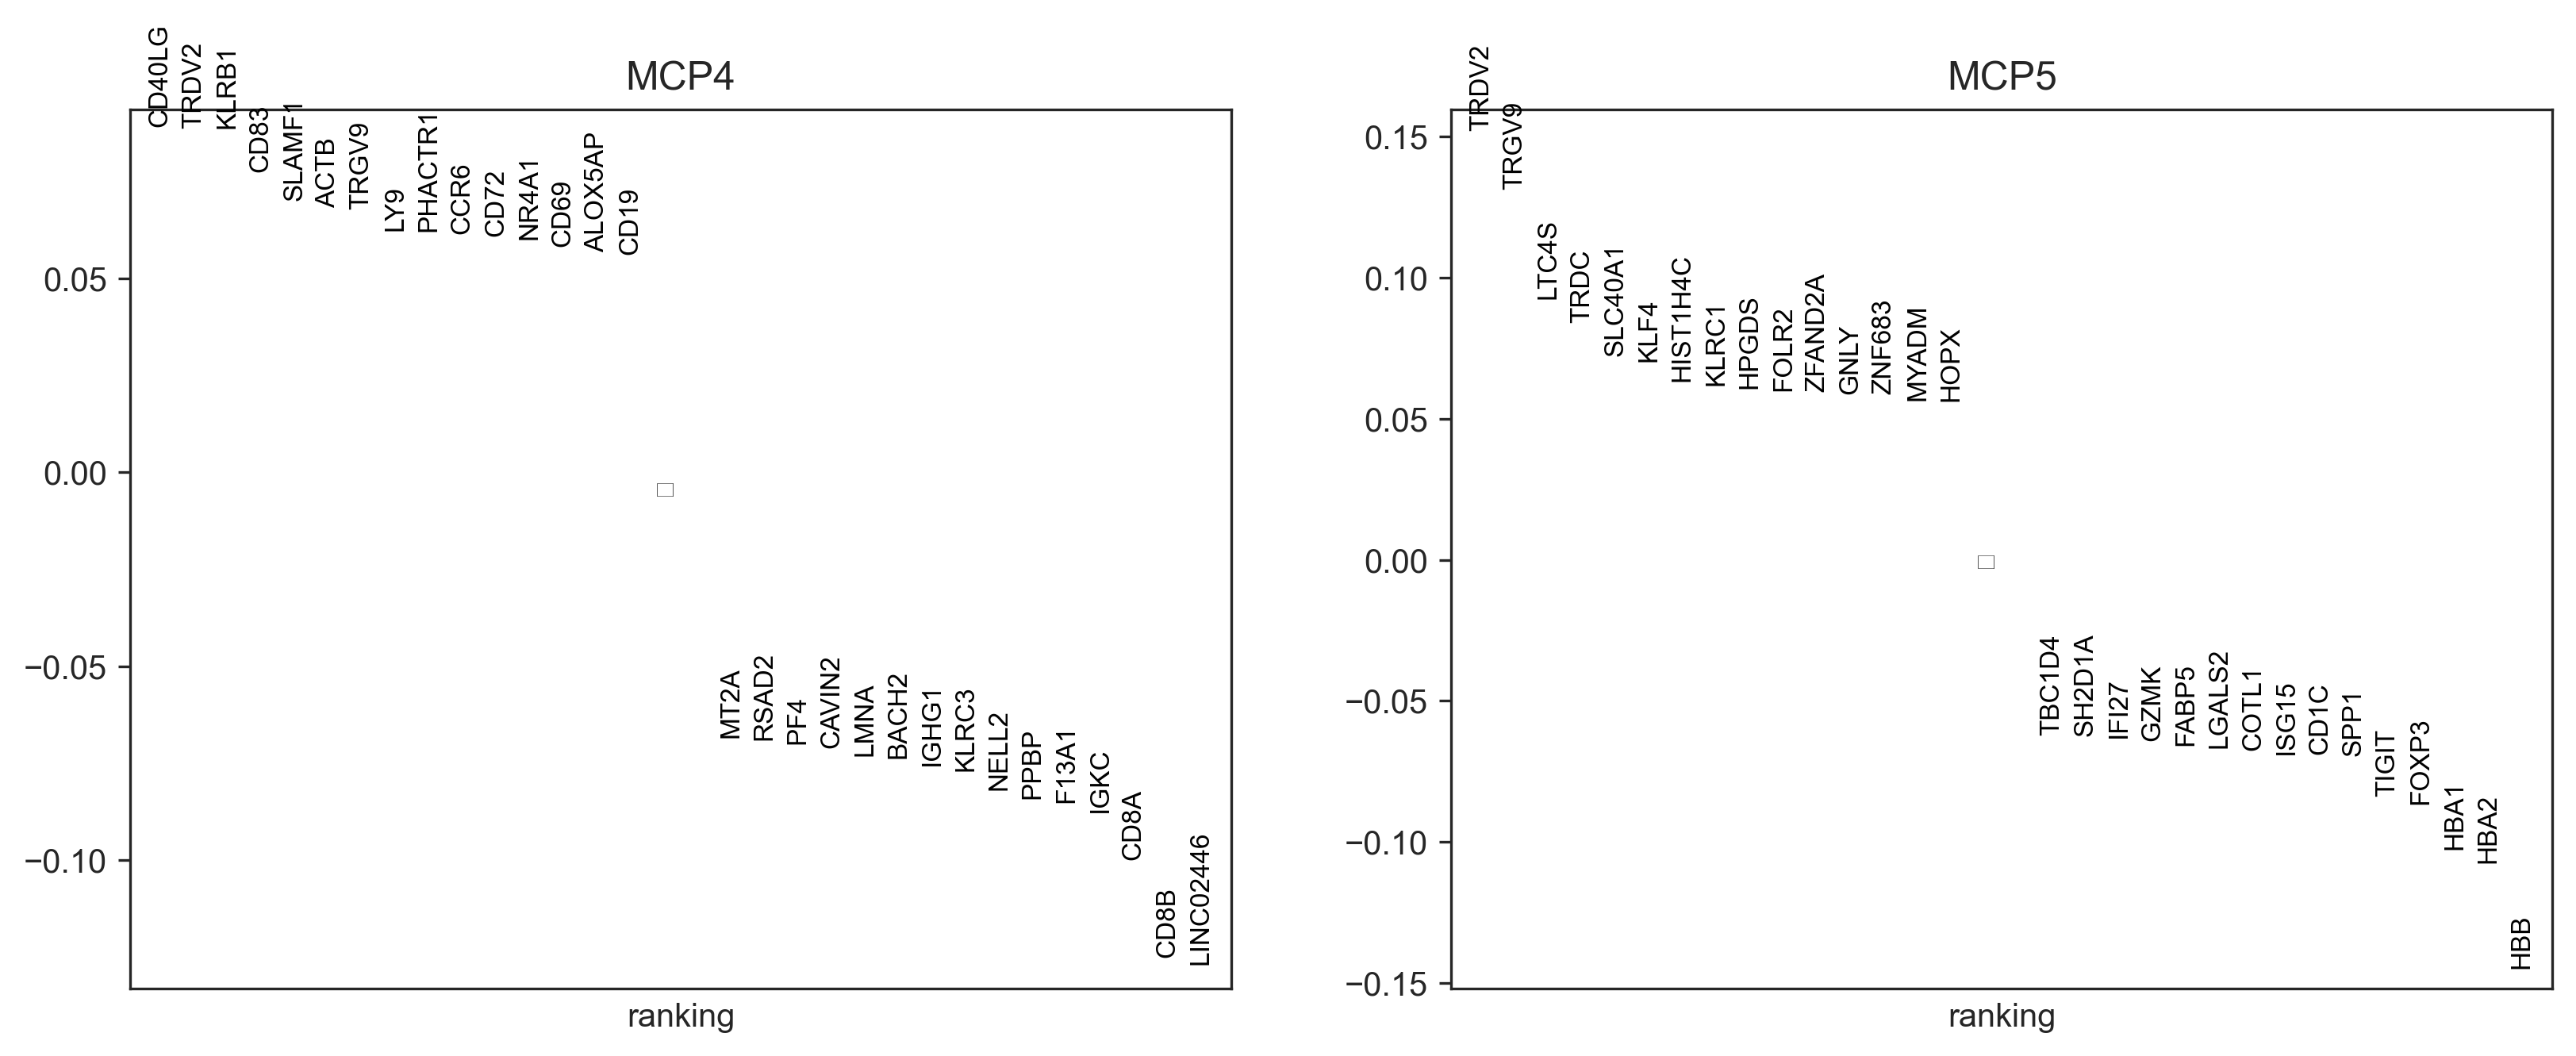

t_pB-IGHG1


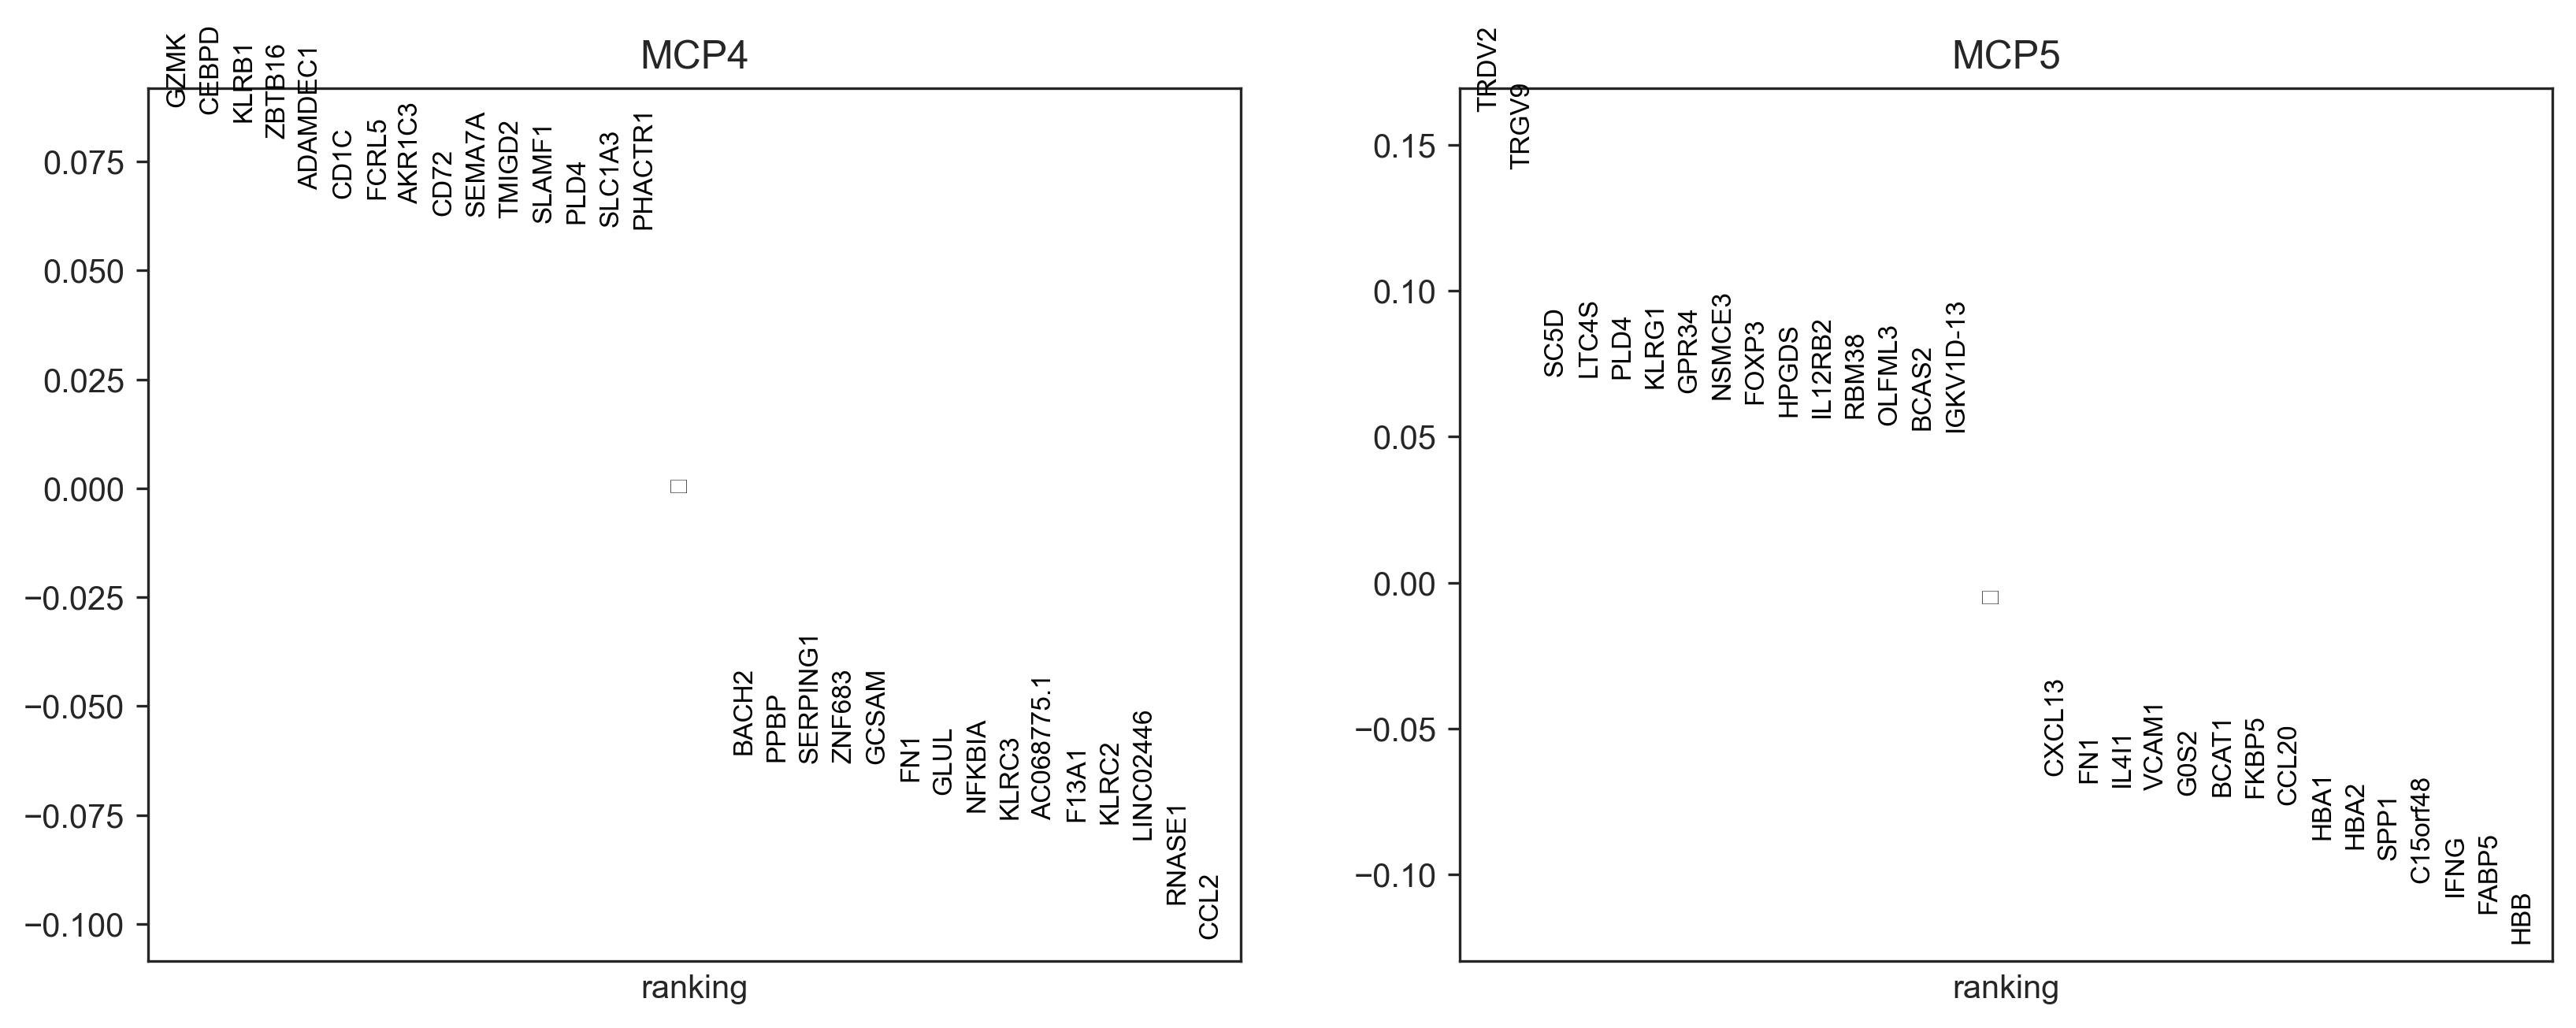

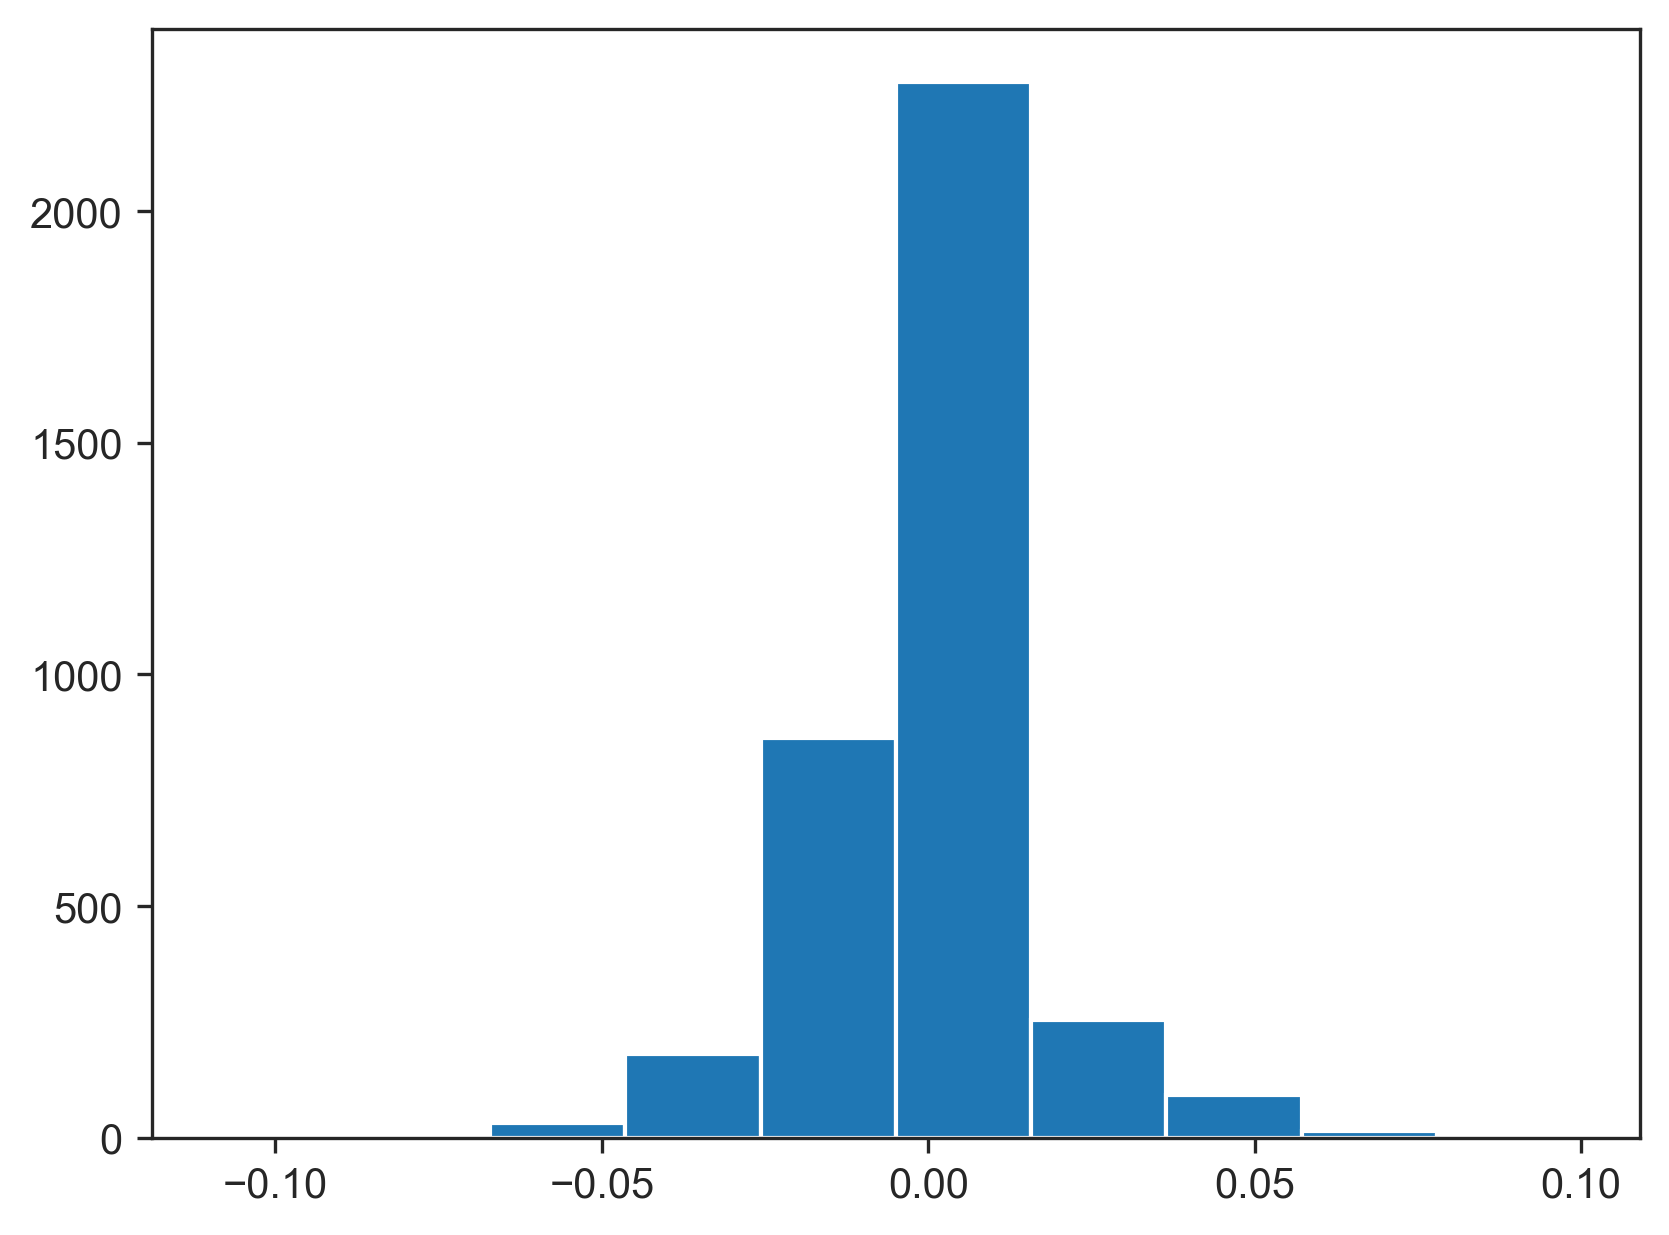

In [137]:
plt.hist(ldings['t_Bmem-CD27'].varm['MCPs'][:,4])
plt.show()
a['ct_subs_loadings']=ldings

In [139]:
### MCP genes from high/low split
def get_genes(ct_subs, mcp="mcp_4", fraction = 0.1):
    """
    Perform gene ranking analysis on subpopulations based on a marker gene expression.

    This function takes a dictionary of subpopulations and their corresponding
    single-cell RNA-seq data, performs gene ranking analysis on each subpopulation,
    and returns a dictionary containing the results.

    Parameters:
    ct_subs (dict): A dictionary where keys are subpopulation names and values
                    are Anndata objects containing single-cell RNA-seq data.
    mcp (str, optional): The name of the marker gene expression column. Default is "mcp_4".
    fraction (float, optional): Fraction of extreme cells to consider for gene ranking.
                               Should be between 0 and 1. Default is 0.1.

    Returns:
    dict: A dictionary where keys are subpopulation names and values are Anndata
          objects containing the results of gene ranking analysis.

    Example:
    ct_subs = {
        "subpop1": anndata_obj1,
        "subpop2": anndata_obj2,
        # ... more subpopulations ...
    }
    genes_results = get_genes(ct_subs, mcp="mcp_4", fraction=0.2)
    """
    genes=dict()
    for ct in ct_subs.keys():
        mini = ct_subs[ct]
        mini.obs[mcp]
        mini.obs['extrema'] =pd.qcut(mini.obs[mcp],[0,0 + fraction,1-fraction,1.0], labels = ["low "+mcp+" "+ct,"no","high"+mcp+" "+ct])
        sc.tl.rank_genes_groups(mini,"extrema", groups = ["high"+mcp+" "+ct],reference="low "+mcp+" "+ct)
        genes[ct] = mini#.uns['rank_genes_groups']
    return genes

In [207]:
def get_genes_fixed(ct_subs, mcp="mcp_4", fraction = 0.1):
    """
    Same function as get_genes, but manually add a flag to the .raw saying it's been logarythmized,
    set as raw again, then run (needed due to transfer from Seurat)
    """
    genes=dict()
    for ct in ct_subs.keys():
        mini = ct_subs[ct]
        mini = mini.raw.to_adata()
        mini.uns['log1p']= {'base': None}
        mini.raw = mini
        # this is actually normalized and logged I think?
        #mini.obs[mcp]
        mini.obs['extrema'] =pd.qcut(mini.obs[mcp],[0,0 + fraction,1-fraction,1.0], labels = ["low "+mcp+" "+ct,"no","high"+mcp+" "+ct])
        sc.tl.rank_genes_groups(mini,"extrema", groups = ["high"+mcp+" "+ct],reference="low "+mcp+" "+ct)
        genes[ct] = mini#.uns['rank_genes_groups']
    return genes

In [214]:
a['ct_subs_method2'] = get_genes_fixed(a['ct_subs'])

In [215]:
### MCP genes from DLG solver 
dl = pt.tl.Dialogue(sample_id = "Sample",
                   celltype_key = "Cluster",
                   n_counts_key = "n_counts",
                   n_mpcs = 10)
a['ct_subs_method3'] = a['ct_subs']
for key in a['ct_subs_method3'].keys():
    a['ct_subs_method3'][key] = a['ct_subs_method3'][key].raw.to_adata()


In [218]:
for key in a['ct_subs_method3'].keys():
    a['ct_subs_method3'][key].obs['n_counts'] = a['ct_subs_method3'][key].obs['Number of counts']

In [222]:

ct_subs_various = {"ct_subs_loadings":a['ct_subs_loadings'], "ct_subs_method2":a['ct_subs_method2'],
              'ct_subs_method3':a['ct_subs_method3']}
outfile =  "output/tumor_pre_DLG_normalizeTrue_bssolver_071023_ct_subs_various.pkl"
with open(outfile, 'wb') as pickle_file:
    pkl.dump(ct_subs_various, pickle_file)
pickle_file.close()

In [223]:
all_results, new_mcps = dl.multilevel_modeling(ct_subs=a['ct_subs_method3'],
                                     mcp_scores=a['mcps'],
                                     ws_dict=a['ws'],
                                     confounder="Treatment",
                                   )

dlg_results = {"all_results":all_results, "new_mcps":new_mcps}
outfile =  "output/tumor_pre_DLG_normalizeTrue_bssolver_071023_MCPgenes_fixed.pkl"
with open(outfile, 'wb') as pickle_file:
    pkl.dump(dlg_results, pickle_file)
pickle_file.close()

Output()

10 MCPs identified for t_Bmem-CD27 and t_CD4_Tcm-LMNA.

10 MCPs identified for t_Bmem-CD27 and t_CD4_Treg-FOXP3.

10 MCPs identified for t_Bmem-CD27 and t_CD8_MAIT-KLRB1.

10 MCPs identified for t_Bmem-CD27 and t_CD8_Tem-GZMK.

10 MCPs identified for t_Bmem-CD27 and t_CD8_Trm-ZNF683.

10 MCPs identified for t_Bmem-CD27 and t_Tn-LEF1.

10 MCPs identified for t_Bmem-CD27 and t_mono-FCN1.

In [14]:
#dlg_results = {"all_results":all_results, "new_mcps":new_mcps}
#outfile =  "output/tumor_pre_DLG_normalizeTrue_bssolver_071023_MCPgenes_orig.pkl"
#with open(outfile, 'wb') as pickle_file:
#    pkl.dump(dlg_results, pickle_file)
#pickle_file.close()

with open("output/tumor_pre_DLG_normalizeTrue_bssolver_071023_MCPgenes_fixed.pkl", 'rb') as file:
    dlg_results = pkl.load(file)
file.close()

In [19]:
all_results = dlg_results['all_results']

In [18]:
new_mcps = dlg_results['new_mcps']

In [28]:
new_mcps['t_Bmem-CD27'][0].shape

(537, 7283)

In [33]:
# for cell type in list
# 

all_results['t_Bmem-CD27_vs_t_CD4_Tcm-LMNA']['MCP4']['sig_genes_1']

{'MCP4.up': ['AC016831.7',
  'ARID5B',
  'ATF3',
  'BAG3',
  'BASP1',
  'BCL2A1',
  'BRD2',
  'BTG1',
  'CD69',
  'CHORDC1',
  'CKS2',
  'CREM',
  'CTSZ',
  'CXCR5',
  'DDX3X',
  'DDX5',
  'DNAJA1',
  'DNAJB1',
  'DNAJB4',
  'DNAJB6',
  'DUSP1',
  'DUSP4',
  'DUSP5',
  'EGR1',
  'EGR4',
  'ELF1',
  'FAM177A1',
  'FCRL2',
  'FOS',
  'FOSB',
  'FOSL2',
  'GADD45B',
  'GNG2',
  'GPR18',
  'H2AFX',
  'H2AFZ',
  'H3F3B',
  'HERPUD1',
  'HIST1H4C',
  'HLA-DQA1',
  'HSP90AA1',
  'HSP90AB1',
  'HSPA1A',
  'HSPA1B',
  'HSPA6',
  'HSPA8',
  'HSPB1',
  'HSPD1',
  'HSPE1',
  'HSPH1',
  'ICAM1',
  'IER2',
  'IER5',
  'IFRD1',
  'IGLC2',
  'IGLV3-1',
  'IGLV3-9',
  'JUN',
  'MT-ATP8',
  'NAMPT',
  'NEAT1',
  'NEU1',
  'NFATC2',
  'NFKB1',
  'NFKBID',
  'NFKBIZ',
  'NR4A1',
  'NR4A2',
  'PIM3',
  'PLK2',
  'PMAIP1',
  'PNRC1',
  'PPP1R15A',
  'RASGEF1B',
  'REL',
  'RGCC',
  'RGS1',
  'RGS2',
  'RHOB',
  'SERTAD1',
  'SFPQ',
  'SLC38A2',
  'SNHG12',
  'SOD2',
  'SRSF7',
  'SWAP70',
  'TAGAP',
  'TIPA

In [231]:
def get_mcp_genes(celltype, results,MCP, threshhold=0.70, focal_celltypes = None):
    """
    Extracts MCP genes for the celltype of interest 
    Args: 
    celltype (str): cell type of interest
    results (results object from dl.MultilevelModeling) : results object
    threshhold (float): number between [0,1]. The fraction of cell types compared against which must have the associated MCP gene
    focal_celltypes (None or list): None (compare against all cell types) or a list of other cell types which you want to compare against 
    Returns:
    dict with keys 'up_genes' and 'down_genes' which contain the MCP genes
    
    """
    comparisons = results.keys()
    comparisons = list(comparisons)
    filtered_keys = [key for key in comparisons if celltype in key]
    if focal_celltypes is not None:
        if celltype in focal_celltypes:
            focal_celltypes = [item for item in focal_celltypes if item != celltype]
        filtered_keys = [key for key in filtered_keys if any(foci in key for foci in focal_celltypes)]
    mcp_dict={}
    for key in filtered_keys:
        if key.startswith(celltype):
            mcp_dict[key.split('_vs_')[1]] = results[key][MCP]['sig_genes_1']
        else:
            mcp_dict[key.split('_vs_')[0]] = results[key][MCP]['sig_genes_2']
    genes_dict_up = {}
    genes_dict_down = {}
    for celltype2 in mcp_dict.keys():
        for gene in mcp_dict[celltype2][MCP+".up"]:
            if gene in genes_dict_up:
                genes_dict_up[gene]+=1
            else:
                genes_dict_up[gene] = 1
        for gene in mcp_dict[celltype2][MCP+".down"]:
            if gene in genes_dict_down:
                genes_dict_down[gene]+=1
            else:
                genes_dict_down[gene] = 1
    up_genes_df =  pd.DataFrame.from_dict(genes_dict_up,orient='index')
    down_genes_df = pd.DataFrame.from_dict(genes_dict_down,orient='index')
    
    min_cell_types = np.floor(len(filtered_keys)*threshhold)
    final_output = {}
    final_output['up_genes'] = list(np.unique(up_genes_df[up_genes_df[0] >= min_cell_types].index.values.tolist()))
    final_output['down_genes'] = list(np.unique(down_genes_df[down_genes_df[0]>=min_cell_types].index.values.tolist()))
    return(final_output)

In [232]:
CD4T = get_mcp_genes("t_CD4_Tcm-LMNA", all_results,'MCP4', focal_celltypes = ["t_pB-IGHG1","t_Bmem-CD27"], threshhold = 1)

In [233]:
plasma = get_mcp_genes("t_pB-IGHG1", all_results,'MCP4', focal_celltypes = ["t_CD4_Tcm-LMNA","t_Bmem-CD27"], threshhold = 1)

In [234]:
memory = get_mcp_genes("t_Bmem-CD27", all_results,'MCP4', focal_celltypes = ["t_CD4_Tcm-LMNA","t_pB_IGHG1"], threshhold = 1)

In [235]:
memory2 = get_mcp_genes("t_Bmem-CD27", all_results,'MCP4', focal_celltypes = ["t_Bmem-CD27","t_CD4_Tcm-LMNA","t_pB_IGHG1"], threshhold = 1)

In [236]:
memory

{'up_genes': ['ARL5B',
  'ATF3',
  'BAG3',
  'BCAR3',
  'BCL2A1',
  'BRD2',
  'CCNL1',
  'CD69',
  'CHORDC1',
  'CITED2',
  'DDX21',
  'DDX3X',
  'DDX5',
  'DNAJA1',
  'DNAJB1',
  'DUSP1',
  'DUSP10',
  'DUSP2',
  'DUSP4',
  'DUSP5',
  'EGR1',
  'EIF4A2',
  'EIF5',
  'FOS',
  'FOSB',
  'FOSL2',
  'FUS',
  'GADD45B',
  'GLA',
  'H2AFX',
  'H2AFZ',
  'H3F3B',
  'HLA-DQA1',
  'HSP90AA1',
  'HSP90AB1',
  'HSPA1A',
  'HSPA1B',
  'HSPA8',
  'HSPB1',
  'HSPD1',
  'HSPE1',
  'HSPH1',
  'ICAM1',
  'IER2',
  'IER5',
  'IFRD1',
  'IGLV3-1',
  'ISG20L2',
  'JUN',
  'KLF2',
  'KLF6',
  'MARCKSL1',
  'MCL1',
  'MIR155HG',
  'MRPL18',
  'MT-ATP8',
  'MT-CO3',
  'MT-CYB',
  'MT-ND5',
  'NAMPT',
  'NEAT1',
  'NFAT5',
  'NFKB1',
  'NFKBIA',
  'NFKBID',
  'NFKBIZ',
  'NR4A1',
  'NR4A2',
  'PARP14',
  'PLK2',
  'PNRC1',
  'PPP1R15A',
  'RAB8B',
  'RANBP2',
  'RASGEF1B',
  'REL',
  'RGCC',
  'RGS1',
  'RGS2',
  'SERTAD1',
  'SFPQ',
  'SLAMF7',
  'SLC38A2',
  'SNHG12',
  'SOCS3',
  'SRGN',
  'SRSF2',
  'SRS

In [215]:
CD4T

{'up_genes': ['AC004832.6',
  'AC020916.1',
  'ANKRD37',
  'ANXA1',
  'AREG',
  'BAG3',
  'BRD2',
  'BTG2',
  'CACYBP',
  'CD69',
  'CDKN1A',
  'CDKN1C',
  'CHMP1B',
  'CHORDC1',
  'CKS2',
  'CSRNP1',
  'DDX3X',
  'DDX5',
  'DNAJA1',
  'DNAJB1',
  'DNAJB4',
  'DUSP1',
  'DUSP2',
  'DUSP6',
  'DYNLL1',
  'EGR1',
  'ELF1',
  'EZR',
  'FOS',
  'FOSB',
  'GLA',
  'H1FX',
  'H3F3B',
  'HSP90AA1',
  'HSP90AB1',
  'HSPA1A',
  'HSPA1B',
  'HSPA2',
  'HSPA6',
  'HSPA8',
  'HSPB1',
  'HSPD1',
  'HSPE1',
  'HSPH1',
  'ID1',
  'IER5',
  'IFNG',
  'IGLC2',
  'IGLV2-23',
  'IGLV3-1',
  'IGLV3-9',
  'IGLVI-70',
  'JUN',
  'KLF2',
  'KLF6',
  'LMNA',
  'MAFF',
  'MARCKSL1',
  'MCL1',
  'MYADM',
  'NEU1',
  'NFKBID',
  'NR4A1',
  'NR4A2',
  'NR4A3',
  'PNRC1',
  'PPP1R15A',
  'RALGAPA1',
  'RASGEF1B',
  'RHOB',
  'SDCBP',
  'SERPINH1',
  'SKIL',
  'SOD2',
  'SRGN',
  'STMN1',
  'TAGAP',
  'TUBA1A',
  'UBB',
  'UBC',
  'UBE2S',
  'ZFAND2A',
  'ZFP36L1',
  'ZNF331'],
 'down_genes': ['ACTG2',
  'BGN',
  '

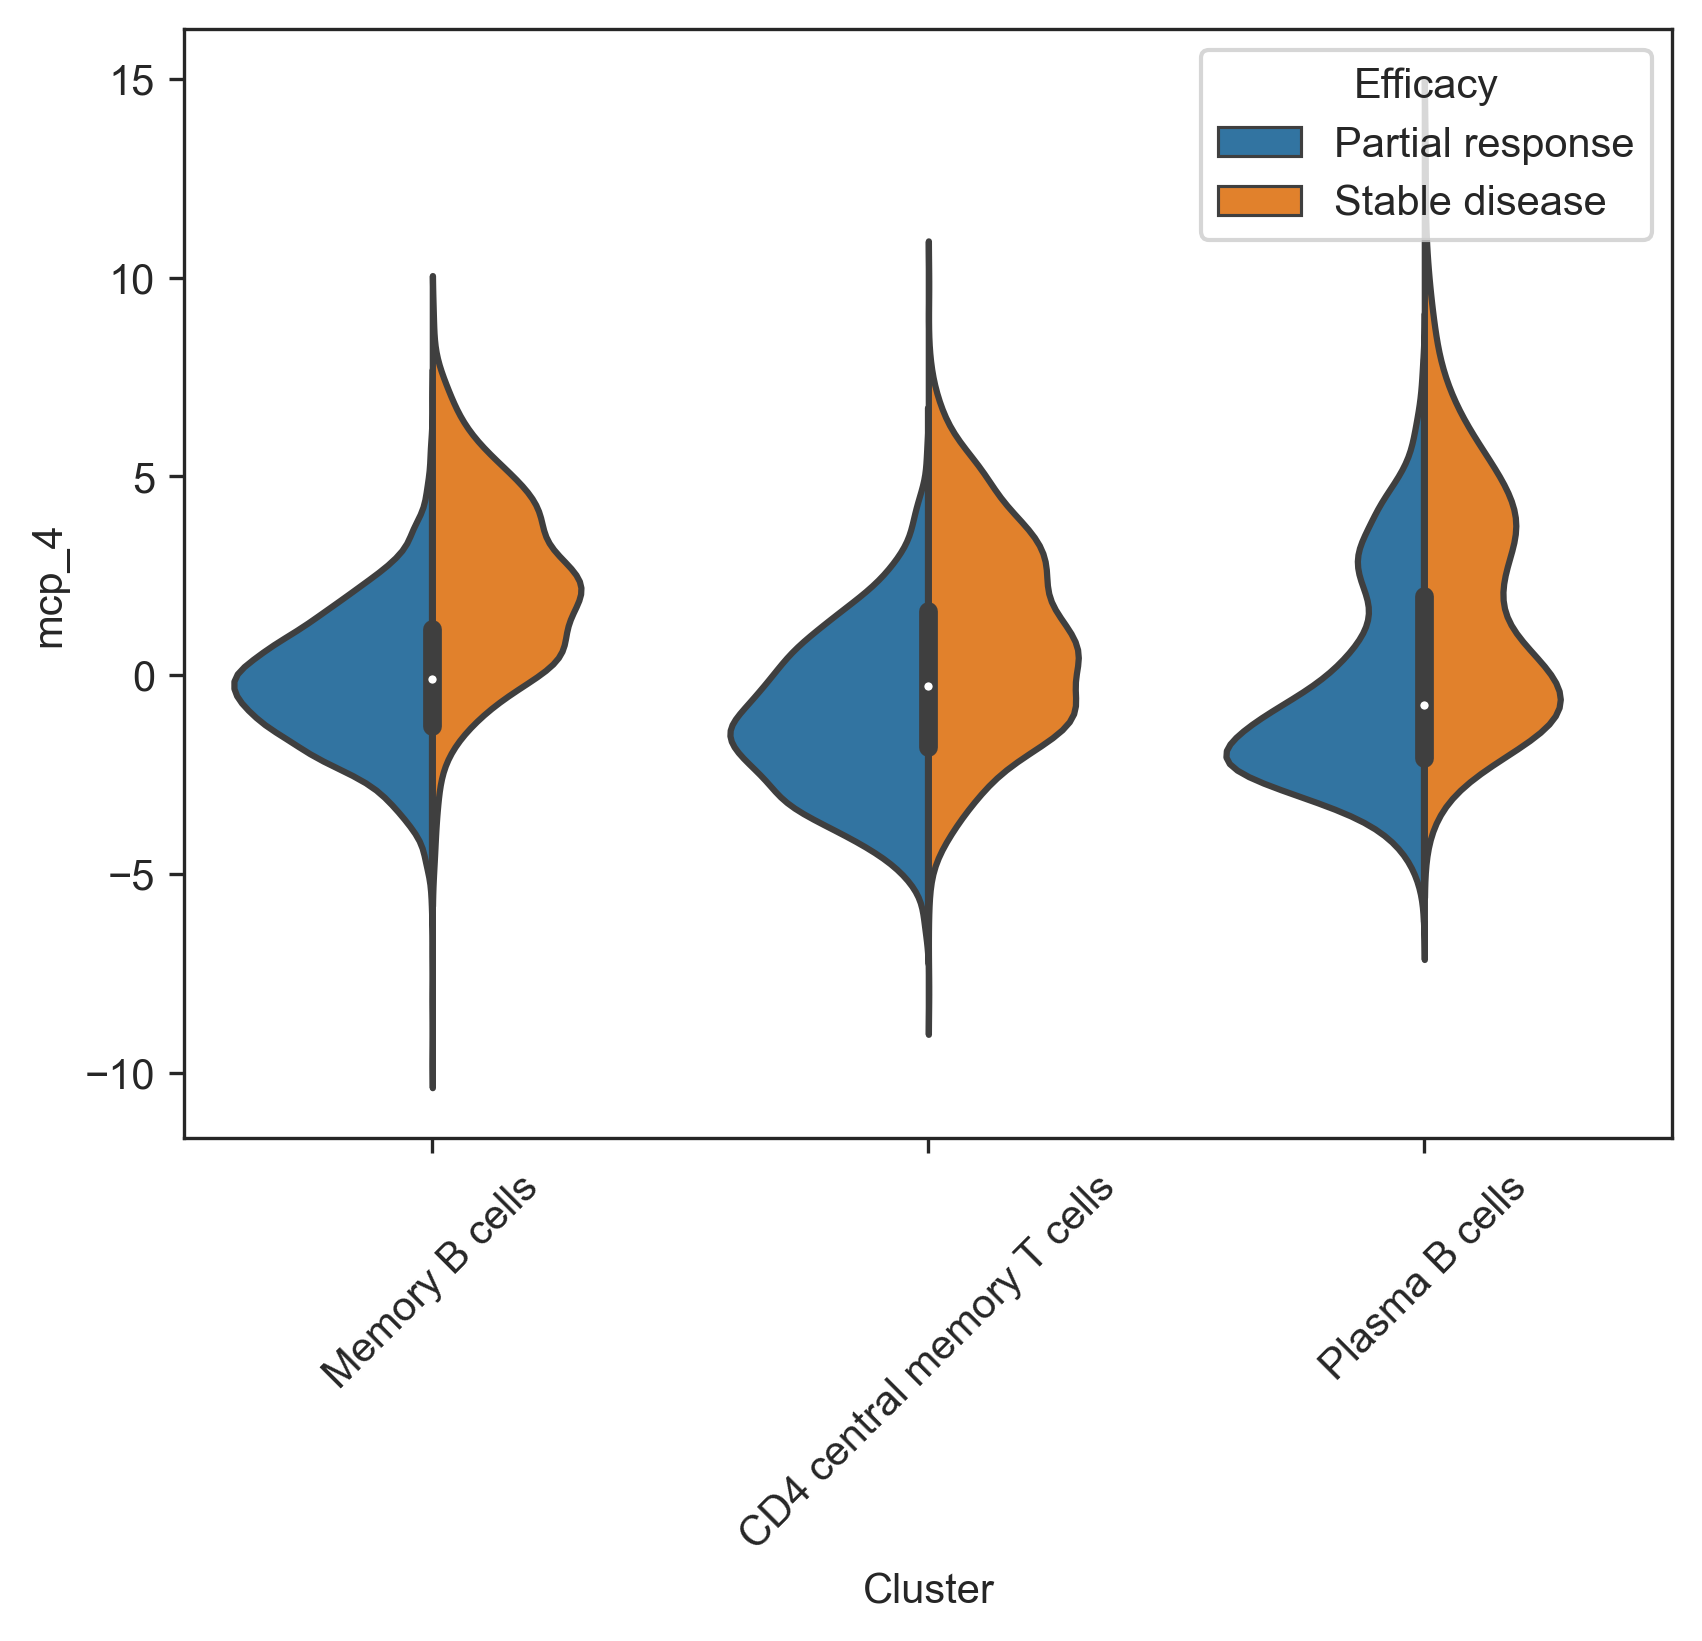

In [209]:
plot_split_violins(mini, mcp = "mcp_4", split="Efficacy", celltype_key = "Cluster")
plt.show()

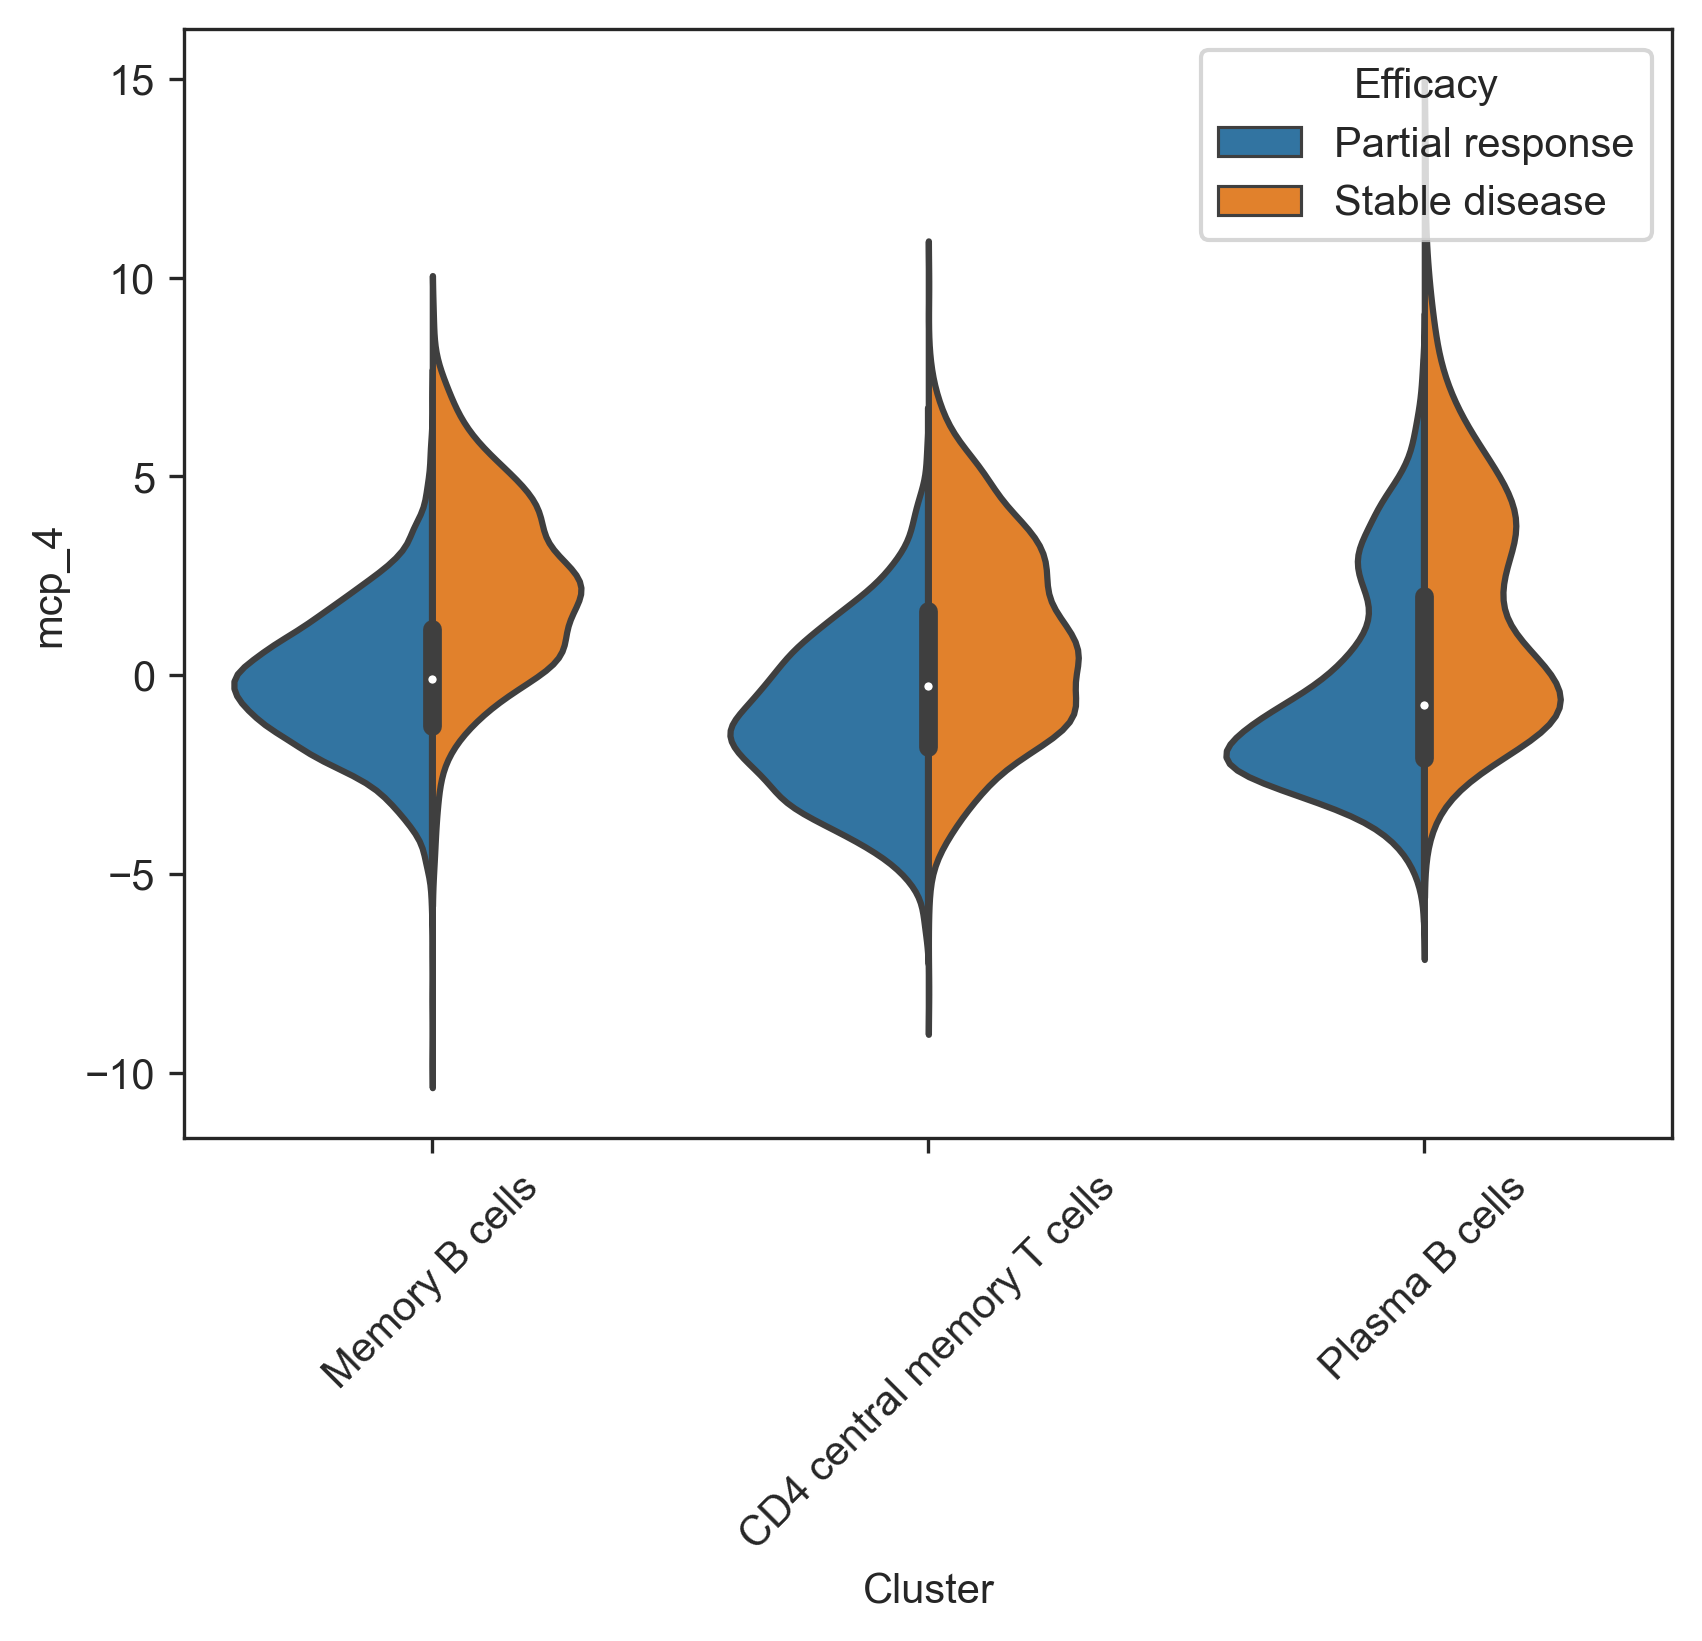

In [213]:
plot_split_violins(mini, mcp = "mcp_4", split="Efficacy", celltype_key = "Cluster")
plt.show()

In [5]:
adata.X

array([[-0.20700525, -0.6224626 , -0.2319455 , ..., -0.00387125,
        -0.00423328, -0.00435749],
       [-0.20700525, -0.6224626 , -0.2319455 , ..., -0.00387125,
        -0.00423328, -0.00435749],
       [-0.20700525, -0.6224626 , -0.2319455 , ..., -0.00387125,
        -0.00423328, -0.00435749],
       ...,
       [-0.20700525, -0.6224626 , -0.2319455 , ..., -0.00387125,
        -0.00423328, -0.00435749],
       [-0.20700525, -0.6224626 , -0.2319455 , ..., -0.00387125,
        -0.00423328, -0.00435749],
       [-0.20700525, -0.6224626 , -0.2319455 , ..., -0.00387125,
        -0.00423328, -0.00435749]], dtype=float32)

In [7]:
tutorial.

AnnData object with n_obs × n_vars = 5374 × 6329
    obs: 'nCount_RNA', 'nFeature_RNA', 'cellQ', 'gender', 'location', 'clinical.status', 'cell.subtypes', 'pathology', 'origin', 'subset'
    var: 'name'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [8]:
!conda list

# packages in environment at /Users/tessa/miniforge3/envs/pertpy5:
#
# Name                    Version                   Build  Channel
_r-mutex                  1.0.1               anacondar_1    conda-forge
adjusttext                0.7.3                    pypi_0    pypi
anndata                   0.8.0                    pypi_0    pypi
appnope                   0.1.3                    pypi_0    pypi
arrow                     1.2.3                    pypi_0    pypi
arviz                     0.14.0                   pypi_0    pypi
asttokens                 2.2.1                    pypi_0    pypi
backcall                  0.2.0                    pypi_0    pypi
bwidget                   1.9.14               hce30654_1    conda-forge
bzip2                     1.0.8                h3422bc3_4    conda-forge
c-ares                    1.18.1               h3422bc3_0    conda-forge
ca-certificates           2022.12.7            h4653dfc_0    conda-forge
cairo                     1.16.0     

In [34]:
c = a['ct_subs']['t_Bmem-CD27']

In [35]:
c

AnnData object with n_obs × n_vars = 7283 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'mcp_0', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5', 'mcp_6', 'mcp_7', 'mcp_8', 'mcp_9'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [38]:
d = adata[adata.obs['Cluster'] == "t_Bmem-CD27"].copy()

In [39]:
d

AnnData object with n_obs × n_vars = 7283 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'mcp_0', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5', 'mcp_6', 'mcp_7', 'mcp_8', 'mcp_9'
    obsm: 'X_pca', 'X_umap'

In [40]:
c

AnnData object with n_obs × n_vars = 7283 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'mcp_0', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5', 'mcp_6', 'mcp_7', 'mcp_8', 'mcp_9'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [43]:
adata

AnnData object with n_obs × n_vars = 42550 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'mcp_0', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5', 'mcp_6', 'mcp_7', 'mcp_8', 'mcp_9'
    obsm: 'X_pca', 'X_umap'

In [55]:


padj = stats.false_discovery_control(a['pvals'], axis=1, method='bh')

AttributeError: module 'scipy.stats' has no attribute 'false_discovery_control'

In [56]:
from scipy.stats import false_discovery_control

ImportError: cannot import name 'false_discovery_control' from 'scipy.stats' (/Users/tessa/miniforge3/envs/pertpy5/lib/python3.9/site-packages/scipy/stats/__init__.py)

In [59]:
!conda list

# packages in environment at /Users/tessa/miniforge3/envs/pertpy5:
#
# Name                    Version                   Build  Channel
_r-mutex                  1.0.1               anacondar_1    conda-forge
adjusttext                0.7.3                    pypi_0    pypi
anndata                   0.8.0                    pypi_0    pypi
appnope                   0.1.3                    pypi_0    pypi
arrow                     1.2.3                    pypi_0    pypi
arviz                     0.14.0                   pypi_0    pypi
asttokens                 2.2.1                    pypi_0    pypi
backcall                  0.2.0                    pypi_0    pypi
bwidget                   1.9.14               hce30654_1    conda-forge
bzip2                     1.0.8                h3422bc3_4    conda-forge
c-ares                    1.18.1               h3422bc3_0    conda-forge
ca-certificates           2022.12.7            h4653dfc_0    conda-forge
cairo                     1.16.0     

In [60]:
! pip show specloud pertpy

Name: pertpy
Version: 0.4.0
Summary: Perturbation Analysis in the Scanpy ecosystem.
Home-page: https://github.com/theislab/pertpy
Author: Lukas Heumos
Author-email: lukas.heumos@posteo.net
License: MIT
Location: /Users/tessa/miniforge3/envs/pertpy5/lib/python3.9/site-packages
Requires: adjusttext, arviz, click, decoupler, ipywidgets, leidenalg, muon, numba, numpyro, plotnine, protobuf, pypi-latest, pyqt5, PyYAML, requests, rich, scanpy, scikit-misc, scipy, sparsecca, statannotations, switchlang, toytree
Required-by: 


In [13]:
bmem = a['ct_subs']['t_Bmem-CD27']

In [14]:
bmem.raw.X

<7283x22173 sparse matrix of type '<class 'numpy.float32'>'
	with 8008755 stored elements in Compressed Sparse Row format>

In [15]:
bmem.raw.var_names

Index(['AL627309.1', 'AL669831.5', 'FAM87B', 'LINC00115', 'NOC2L', 'KLHL17',
       'PLEKHN1', 'HES4', 'ISG15', 'AGRN',
       ...
       'AL805961.2', 'OR14A16', 'AC117465.1', 'AC021393.1', 'AL450263.1',
       'LINC02318', 'IGHVIV-44-1', 'AC131956.2', 'LINC02376', 'AC025572.1'],
      dtype='object', length=22173)

In [16]:
bmem.varm['PCs'].shape

(4000, 50)

In [19]:
adata.obsm['X_pca'].shape

(42550, 50)

In [20]:
zhang = sc.read_h5ad("zhang_with_PCs.h5ad")

In [24]:
zhang.varm['PCs'].shape

(4000, 50)

In [27]:
bmem.varm['PCs'][bmem.varm['PCs']==0].sum()

0.0

In [30]:
zhang.var['highly_variable']

HES4           True
ISG15          True
TNFRSF18       True
TNFRSF4        True
SCNN1D         True
               ... 
CELA2A         True
DEFA1          True
AC026398.1     True
TRIM64B        True
IGHVIV-44-1    True
Name: highly_variable, Length: 4000, dtype: bool

In [54]:
vf = pd.read_csv("data/var_features.csv")

sd = pd.read_csv("data/scale_data_rownames.csv")

In [52]:
vf.x.isin(zhang.var_names).sum()

1466

In [59]:
zhang.var

n_cells  highly_variable  highly_variable_rank     means  \
HES4           23417             True                1434.0  0.071599   
ISG15         158629             True                 932.0  0.561768   
TNFRSF18       28622             True                 694.0  0.097566   
TNFRSF4        31328             True                 499.0  0.111665   
SCNN1D           760             True                2908.0  0.002160   
...              ...              ...                   ...       ...   
CELA2A            10             True                1014.0  0.000015   
DEFA1             19             True                1605.0  0.000053   
AC026398.1        10             True                1025.0  0.000021   
TRIM64B           10             True                 300.0  0.000037   
IGHVIV-44-1       11             True                 401.0  0.000036   

             variances  variances_norm      mean       std  
HES4          0.119632        1.188918  0.071599  0.345879  
ISG15         0.814494        1.254421  0.561768  0.902493  
TNFRSF18      0.176940        1.306843  0.097566  0.420642  
TNFRSF4       0.216220        1.402567  0.111665  0.464995  
SCNN1D        0.003423        1.112605  0.002160  0.058504  
...                ...             ...       ...       ...  
CELA2A        0.000020        1.239102  0.000015  0.004428  
DEFA1         0.000082        1.176139  0.000053  0.009056  
AC026398.1    0.000029        1.236839  0.000021  0.005343  
TRIM64B       0.000076        1.626420  0.000037  0.008701  
IGHVIV-44-1   0.000066        1.488486  0.000036  0.008147  

[4000 rows x 8 columns]